## Constant coefficients for the equation - Comparison with Central Difference scheme with IC and BCs.

In [2]:
from IPython.core.display import HTML
css_file = './custom.css'
HTML(open(css_file, "r").read())

$$ \frac {\partial U}{\partial t} = D\frac {\partial^2 U}{\partial x^2} - v\frac {\partial U}{\partial x} + c*U + d $$

$$ IC: U(x, 0) = \exp(-x**2) $$ 
$$ BC: Periodic: U(0, t) = U(1, t) $$
$$                 \frac {\partial U(0, t)}{\partial x} =  \frac {\partial U(1, t)}{\partial t} $$

In [3]:
from scipy.linalg import solve
# Define the equation parameters
from scipy.special import erfc
import pandas as pd
import numpy as np
import scipy.integrate
from numpy import exp
import matplotlib.pyplot as plt

First, we take a **Fourier transform** of the initial data:

$$\hat{u}(t=0;\xi) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty u_0(x) e^{-i\xi x}dx.$$

Then each mode **evolves** according to the solution of the ODE above:

$$\hat{u}'(t; \xi) = e^{(-i \xi a - \epsilon \xi^2)t} \hat{u}(0;\xi).$$

Finally, we construct the solution again by taking the **inverse Fourier transform**.  This just means summing up all the Fourier modes:

$$u(x,t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty \hat{u}(t; \xi) e^{i\xi x}d\xi.$$

Many important applications of pseudospectral methods involve evolution PDEs of the form

$$
    u_t = f(u) + L(u)
$$

where $f$ is a non-stiff, nonlinear operator and $L$ is a stiff, linear operator.  Most often, $f$ involves at most first-order derivatives while $L$ involves higher-order derivatives.  An example that we have already dealt with is the KdV equation

$$
    u_t + uu_x + u_{xx} = 0
$$

in which $f(u)=-uu_x$ and $L(u)=-u_{xx}$.  Other applications which share this overall structure include many other dispersive wave models, the Navier-Stokes equations, the Kuramoto-Sivashinsky equation, and many more.

Application of an explicit Runge-Kutta method to such problems is requires that the time step satisfy a condition of the form

$$
    \Delta t \le C (\Delta x)^j
$$

where $j$ is the order of the highest derivative in $L(u)$ and $C$ is a constant depending on the spectrum of $g$ and the stability region of the RK method.  This is inefficient, since discretizations based on spectral differentiation in space and high order RK in time can usually give a reasonable local error with $\Delta t \approx \Delta x$.  The computational cost of an explicit time discretization becomes especially noticeable if a large number of spatial grid points is required to resolve the solution.


In [6]:
def testAB_PS(a, b, c, d, nx, nt):

    L = np.pi
    T = 4.0


    x = np.linspace(-L, L, nx+1)
    t = np.linspace(0, T, nt+1)
    
    u = np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)

    # Discretization of space and time
    dx = 2*L/(nx+1)
    # dt = 0.1*dx**2/D#T/(nt-1)
    # dx = L/(nx+1)
    dt = T/(nt+1)


    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = a*dt/dx
        beta = b*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt    


        # Applying second order periodic boundary conditions
        # bt = d*dt+u_CDI;
        # kk = np.zeros(2)
        # bi = [*kk, *bt]

        # A[0, 0]=0;
        # A[0, 1]= 1
        # A[0, N]= -1
        # A[0, N+1]=0

        # A[1, 0] = -1
        # A[1,1] = 0
        # A[1, 2] = 1
        # A[1, N-1] = 1
        # A[1, N] = 0 
        # A[1, N+1] = -1


        # Boundary condition
        # A[0, 0] = -3
        # A[0, 1] = 4
        # A[0, 2] = -1
        # bi[0] = 0

        # A[N, N] = 3
        # A[N, N-1] = -4
        # A[N, N-2] = 1
        # bi[N] = 0


        # A[0,0] = 1.0
        # # A[N,N] = 1.0

        # bi[0] = l
        # bi[N] = r


        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    # u = np.exp(-((x+0.5)**2)/(0.00125))
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_QI_PSTD = np.zeros(nt)

    u_CDI=u;
    plt.plot(x,u)
    for n in range(nt):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt)
        U_CDI[:, n] = u_CDI

    #plt.plot(u_CDI, label='Final')
    #plt.show()
    #plt.close()

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()


    k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    k2=k**2;

    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))
    U_psk = np.zeros((nx+1, nt+1))
    #plt.figure()
    #plt.plot(xin, u, color = 'b', label = "initial")
    # left = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(0.5 - t)**2)/(0.00125 + 0.04*t)))
    # right = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(1.5 - t)**2)/(0.00125 + 0.04*t)))

    # Solving over time
    for i in range(nt+1): # 
        
        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-b*k**2 + a*1j*k+c)*dt) 
        # print(np.shape(uk))    
        u = np.fft.irfft(uk) #+ d*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)


    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    U_psk = np.zeros((nx+1, nt+1))
    error_2norm_PSTDI_PSTDK = np.zeros(nt+1)
    
    error_2norm_CDI_PSTDK = np.zeros(nt+1)
    # Spatial grid
    m=nx+1                            # Number of grid points in space
    L = np.pi                   # Width of spatial domain
    x = np.arange(-m/2,m/2)*(2*L/m)   # Grid points
    dx = x[1]-x[0]                  # Grid spacing

    # Temporal grid
    tmax=T     # Final time
    N = nt+1       # number grid points in time
    dt = tmax/N   # interval between output times

    xi = np.fft.fftfreq(m)*m*np.pi/L  # Wavenumber "grid"
    xi = 2*np.pi*np.fft.fftfreq(nx+1, 2*L/(nx))
    
    # k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    
    
    # (this is the order in which numpy's FFT gives the frequencies)

    # Initial data
    u = np.exp(-x**2)# np.sin(2*x)**2 * (x<-L/4)
    uhat0 = np.fft.fft(u)
    plt.plot(x,u)
    epsilon=b  # Diffusion coefficient
    # a = 1.0       # Advection coefficient

    print(np.shape(xi))
    print(np.shape(u))
    # Now we solve the problem
    for i in range(0,N):
        t = i*dt
        uhat = np.exp((1.j*xi*a - epsilon*xi**2)*t) * uhat0
        u = np.real(np.fft.ifft(uhat)) #+ d*t
        
        U_psk[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)
        error =  U_ps[:, i] - u
        error_2norm_PSTDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)

    
    fig = plt.figure()  
    plt.imshow((U_psk), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTDK")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDK - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    plt.figure();
    # plt.plot(x, ui, '-', color='g', label = 'Initial'); 
    plt.plot(x, U_CDI[:, int(nt/2)], '-*', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, int(nt/2)], '-+', color = 'r', label = 'Spectral Method');
    plt.plot(x, U_psk[:, int(nt/2)], '-.', color = 'g', label = 'Ketchinson Spectral Method');
    
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1], U_psk[:, nt-1]]
    
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    
    plt.plot(error_2norm_CDI_PSTDK[0:nt], '.', label = 'PSTDK_CDI')
    
    plt.plot(error_2norm_PSTDI_PSTDK[0:nt], '.', label = 'PSTDI_PSTDK')
    plt.legend()
    plt.show()
    plt.close()
    return res

In [62]:
def testAB_PSCH(a, b, c, d, nx, nt):

    L = 1.0
    T = 4.0


    x = np.linspace(-L, L, nx+1)
    t = np.linspace(0, T, nt+1)
    
    u = np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)

    # Discretization of space and time
    dx = 2*L/(nx+1)
    # dt = 0.1*dx**2/D#T/(nt-1)
    # dx = L/(nx+1)
    dt = T/(nt+1)


    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = a*dt/dx
        beta = b*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt    


        # Applying second order periodic boundary conditions
        # bt = d*dt+u_CDI;
        # kk = np.zeros(2)
        # bi = [*kk, *bt]

        # A[0, 0]=0;
        # A[0, 1]= 1
        # A[0, N]= -1
        # A[0, N+1]=0

        # A[1, 0] = -1
        # A[1,1] = 0
        # A[1, 2] = 1
        # A[1, N-1] = 1
        # A[1, N] = 0 
        # A[1, N+1] = -1


        # Boundary condition
        # A[0, 0] = -3
        # A[0, 1] = 4
        # A[0, 2] = -1
        # bi[0] = 0

        # A[N, N] = 3
        # A[N, N-1] = -4
        # A[N, N-2] = 1
        # bi[N] = 0


        # A[0,0] = 1.0
        # # A[N,N] = 1.0

        # bi[0] = l
        # bi[N] = r


        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    # u = np.exp(-((x+0.5)**2)/(0.00125))
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_QI_PSTD = np.zeros(nt)

    u_CDI=ui;
    plt.plot(x,u)
    for n in range(nt):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt)
        U_CDI[:, n] = u_CDI

    #plt.plot(u_CDI, label='Final')
    #plt.show()
    #plt.close()

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()
    
    U_CH = np.zeros((nx+1, nt+1))
    error_2norm_CDI_CH = np.zeros(nt+1)

    u_CH=np.exp(-x**2);
    
    # ==========
    # Method 1
    # == Output == 
    # D: Chebyshev derivative matrix
    # x: Chebyshev collocation points
    # ==========
    def chebDiffMtx(N):
        if N == 0:
            D = 0
            x = 1
        else:
            theta = np.linspace(0,np.pi,num=N+1,endpoint=True).reshape((N+1,1))
            #x = np.cos(theta)
            x = -np.sin(theta-np.pi/2)

            c=np.vstack((2,np.ones((N-1,1)),2))*(-1)**np.arange(0,N+1).reshape((N+1,1))
            X = np.tile(x,(1,N+1))
            dX = X-X.T
            # off-diagonal entries
            D = (c@(1/c).T) / (dX+np.eye(N+1))
            D = D-np.diag( np.sum(D,axis=1) )
        return (D,x)
    
#     def AdvDiffusion(N,dt,T):
    # iter_max = int(T/dt)
    # Initialize a (N+1)x(iter_max+1) array to store v(x_i,t_n) 
    V = np.zeros((nx+1,nt+1))

    # Create the coefficient matrix of the linear system
    [D,x] = chebDiffMtx(nx)
    L = b *(D@D) + a * D + c
    print(np.shape(L))
    print(np.shape(D@D))
    print(np.shape(D))
    L = np.eye(nx+1)-dt*L
    A = np.vstack( (  D[nx,0:nx+1], L[1:nx,0:nx+1] , D[nx,0:nx+1] ) )
    bs = np.zeros((nx+1, 1))
    # Create initial function
    v =ui
    V[:,0] = v.flatten()
    print(np.shape(A))
    print(np.shape(v))
    print(np.shape(bs))
    print(np.shape(v[1:nx]))
    print(A)
    print(bs)
    for k in range(nt+1):
        # Create the constant term vector of the linear system
        
        bs = v# np.vstack( ( v[1:nx] , 0 ) )     
        bs[0]=0.
        bs[nx]=0.
        # Sovle the linear system
        v = solve(A,bs)
        # Add V_0 = 0 to the solution
        # v = np.vstack((0,v))
        print(k)
        # Store v to V[:,k]
        V[:,k] = v.flatten()
        U_CH[:,k] = v.flatten()
        error = U_CDI[:, k] - v.flatten()
        error_2norm_CDI_CH[k] = np.linalg.norm(error)/np.sqrt(nx)
    
    print(U_CH[:,-1])
    fig = plt.figure()  
    plt.imshow((U_CH), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with Cheby")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "Cheby - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    
    
    
    
    

    k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    k2=k**2;

    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))
    U_psk = np.zeros((nx+1, nt+1))
    #plt.figure()
    #plt.plot(xin, u, color = 'b', label = "initial")
    # left = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(0.5 - t)**2)/(0.00125 + 0.04*t)))
    # right = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(1.5 - t)**2)/(0.00125 + 0.04*t)))

    # Solving over time
    for i in range(nt+1): # 
        
        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-b*k**2 + a*1j*k+c)*dt) 
        # print(np.shape(uk))    
        u = np.fft.irfft(uk) #+ d*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)


    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    U_psk = np.zeros((nx+1, nt+1))
    error_2norm_PSTDI_PSTDK = np.zeros(nt+1)
    
    error_2norm_CDI_PSTDK = np.zeros(nt+1)
    # Spatial grid
    m=nx+1                            # Number of grid points in space
    L = np.pi                   # Width of spatial domain
    x = np.arange(-m/2,m/2)*(2*L/m)   # Grid points
    dx = x[1]-x[0]                  # Grid spacing

    # Temporal grid
    tmax=T     # Final time
    N = nt+1       # number grid points in time
    dt = tmax/N   # interval between output times

    xi = np.fft.fftfreq(m)*m*np.pi/L  # Wavenumber "grid"
    xi = 2*np.pi*np.fft.fftfreq(nx+1, 2*L/(nx))
    
    # k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    
    
    # (this is the order in which numpy's FFT gives the frequencies)

    # Initial data
    u = np.exp(-x**2)# np.sin(2*x)**2 * (x<-L/4)
    uhat0 = np.fft.fft(u)
    plt.plot(x,u)
    epsilon=b  # Diffusion coefficient
    # a = 1.0       # Advection coefficient

    print(np.shape(xi))
    print(np.shape(u))
    # Now we solve the problem
    for i in range(0,N):
        t = i*dt
        uhat = np.exp((1.j*xi*a - epsilon*xi**2)*t) * uhat0
        u = np.real(np.fft.ifft(uhat)) #+ d*t
        
        U_psk[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)
        error =  U_ps[:, i] - u
        error_2norm_PSTDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)

    
    fig = plt.figure()  
    plt.imshow((U_psk), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTDK")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDK - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    plt.figure();
    # plt.plot(x, ui, '-', color='g', label = 'Initial'); 
    plt.plot(x, U_CDI[:, int(nt/2)], '-*', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, int(nt/2)], '-+', color = 'r', label = 'Spectral Method');
    plt.plot(x, U_psk[:, int(nt/2)], '-.', color = 'g', label = 'Ketchinson Spectral Method');
    
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1], U_psk[:, nt-1], U_CH[:, nt-1]]
    
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    
    plt.plot(error_2norm_CDI_PSTDK[0:nt], '.', label = 'PSTDK_CDI')
    
    plt.plot(error_2norm_PSTDI_PSTDK[0:nt], '.', label = 'PSTDI_PSTDK')
    plt.legend()
    plt.show()
    plt.close()
    return res

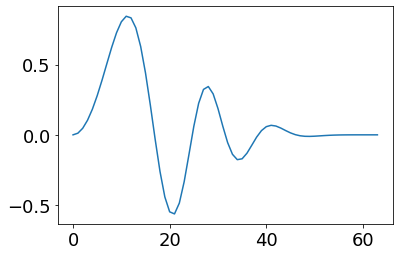

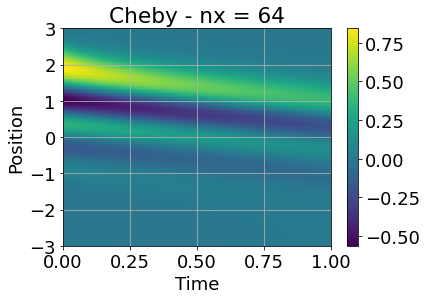

[0.00000000e+00 7.75714925e-03 3.10239233e-02 6.97864256e-02
 1.24021906e-01 1.93699364e-01 2.78780379e-01 3.79220124e-01
 4.94968563e-01 6.25971775e-01 7.72173376e-01 9.33515987e-01
 1.10994271e+00 1.30139854e+00 1.50783167e+00 1.72919461e+00
 1.96544508e+00 2.21654661e+00 2.48246873e+00 2.76318673e+00
 3.05868058e+00 3.36893208e+00 3.69391660e+00 4.03357920e+00
 4.38776821e+00 4.75606938e+00 5.13744589e+00 5.52958181e+00
 5.92792609e+00 6.32470417e+00 6.70852759e+00 7.06537027e+00
 7.38122000e+00 7.64568481e+00 7.85493267e+00 8.01243855e+00
 8.12721243e+00 8.21058359e+00 8.27316121e+00 8.32306180e+00
 8.36553750e+00 8.40349466e+00 8.43829087e+00 8.47042516e+00
 8.49999731e+00 8.52696384e+00 8.55126189e+00 8.57286147e+00
 8.59178333e+00 8.60810132e+00 8.62193788e+00 8.63345654e+00
 8.64285313e+00 8.65034646e+00 8.65616928e+00 8.66055978e+00
 8.66375403e+00 8.66598012e+00 8.66745385e+00 8.66837410e+00
 8.66891283e+00 8.66920125e+00 8.66932868e+00 8.66936367e+00
 8.66936629e+00]


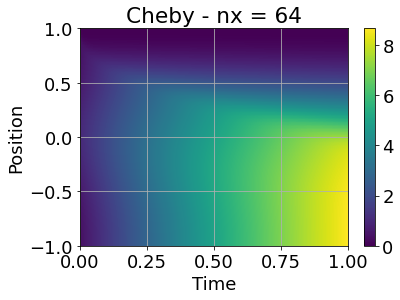

In [75]:
# With [-1,1] limits and using a and b
# ==========
# Method 1
# == Output == 
# D: Chebyshev derivative matrix
# x: Chebyshev collocation points
# ==========
def chebDiffMtx(N):
    if N == 0:
        D = 0
        x = 1
    else:
        theta = np.linspace(0,np.pi,num=N+1,endpoint=True).reshape((N+1,1))
        #x = np.cos(theta)
        x = -np.sin(theta-np.pi/2)
        
        c=np.vstack((2,np.ones((N-1,1)),2))*(-1)**np.arange(0,N+1).reshape((N+1,1))
        X = np.tile(x,(1,N+1))
        dX = X-X.T
        # off-diagonal entries
        D = (c@(1/c).T) / (dX+np.eye(N+1))
        D = D-np.diag( np.sum(D,axis=1) )
    return (D,x)
    
def AdvDiffusion(a, b, c, d, N,dt,T):
    iter_max = int(T/dt)
    # Initialize a (N+1)x(iter_max+1) array to store v(x_i,t_n) 
    V = np.zeros((N+1,iter_max+1))

    # Create the coefficient matrix of the linear system
    [D,x] = chebDiffMtx(N)
    L = b *(D@D)+ a * D + c
    L = np.eye(N+1)-dt*L
    A = np.vstack( ( L[1:N,1:N+1] , D[N,1:N+1] ) )

    # Create initial function
    v = np.exp(-x**2)# 1/4 * ((x/3.+1)**2)* np.sin(np.pi*x)
    V[:,0] = v.flatten()

    for k in range(1,iter_max+1):
        # Create the constant term vector of the linear system
        b = np.vstack( ( v[1:N]+ d , 0 ) )     
        # Sovle the linear system
        v = solve(A,b)
        # Add V_0 = 0 to the solution
        v = np.vstack((0,v))

        # Store v to V[:,k]
        V[:,k] = v.flatten()
    
    return V
U_CH = AdvDiffusion(1.0, 0.01, -0.01, 0.01, 64, 0.001, 1.)
print(U_CH[:,-1])
fig = plt.figure()  
plt.imshow((U_CH), cmap='viridis',  extent=[0, 1., -1, 1], aspect='auto')
plt.colorbar()
plt.title("CD Scheme with Cheby")
plt.xlabel('Time')
plt.ylabel('Position')
title = "Cheby - nx = "+str(63+1)
plt.title(title)
plt.grid(True)
plt.show()
plt.close()
    

63
(64,)
(64,)
(62, 1)
[0.07724534 0.07724534 0.07724534 0.07724534 0.07724534 0.07724534
 0.07724534 0.07724534 0.07724534 0.07724534 0.07724534 0.07724534
 0.07724534 0.07724534 0.07724534 0.07724534 0.07724535 0.07724536
 0.07724542 0.07724565 0.0772465  0.07724957 0.0772599  0.07729244
 0.0773873  0.07764183 0.07826682 0.07966548 0.08251086 0.08776802
 0.09659805 0.11012094 0.12910088 0.15369198 0.18337347 0.21710106
 0.25358355 0.29154774 0.32990039 0.36777589 0.4045118  0.43960157
 0.47265461 0.5033721  0.53153553 0.5570018  0.57970008 0.59962791
 0.61684557 0.63146865 0.64365916 0.65361584 0.66156401 0.66774566
 0.67241009 0.67580557 0.6781726  0.67973916 0.68071589 0.68128606
 0.6815906  0.68172525 0.68176235 0.68176514]


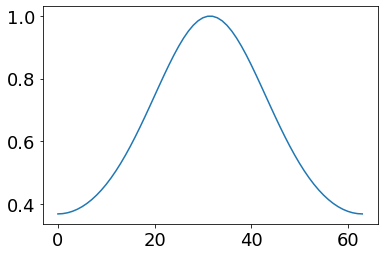

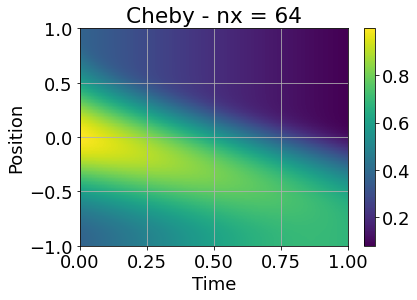

In [102]:
# With du/dx = 0 bc for both ends
# ==========
# Method 1
# == Output == 
# D: Chebyshev derivative matrix
# x: Chebyshev collocation points
# ==========
def chebDiffMtx(N):
    if N == 0:
        D = 0
        x = 1
    else:
        theta = np.linspace(0,np.pi,num=N+1,endpoint=True).reshape((N+1,1))
        #x = np.cos(theta)
        x = -np.sin(theta-np.pi/2)
        
        c=np.vstack((2,np.ones((N-1,1)),2))*(-1)**np.arange(0,N+1).reshape((N+1,1))
        X = np.tile(x,(1,N+1))
        dX = X-X.T
        # off-diagonal entries
        D = (c@(1/c).T) / (dX+np.eye(N+1))
        D = D-np.diag( np.sum(D,axis=1) )
    return (D,x)
    
def AdvDiffusion(a, b, c, d, N,dt,T):
    iter_max = int(T/dt)
    # Initialize a (N+1)x(iter_max+1) array to store v(x_i,t_n) 
    V = np.zeros((N+1,iter_max+1))

    # Create the coefficient matrix of the linear system
    [D,x] = chebDiffMtx(N)
    L = b *(D@D)+ a * D + c
    L = np.eye(N+1)-dt*L
    A = np.vstack( ( D[0,0:N+1], L[1:N,0:N+1] , D[N,0:N+1] ) )
    
    # Create initial function
    v = np.exp(-x**2)# 1/4 * ((x/3.+1)**2)* np.sin(np.pi*x)
    plt.plot(v)
    V[:,0] = v.flatten()
    print(N)
    print(np.shape(V[:, 0]))
    print(np.shape(v.flatten()))
    print(np.shape(v[1:N]))
    for k in range(1,iter_max+1):
        # Create the constant term vector of the linear system
        bs = np.vstack( ( 0, v[1:N]+ d*dt , 0 ) )     
        
        # Sovle the linear system
        v = solve(A,bs)
        # Add V_0 = 0 to the solution
        # v = np.vstack((0,v))

        # Store v to V[:,k]
        V[:,k] = v.flatten()

    return V
U_CH = AdvDiffusion(1.0, 0.01, -0.01, 0.01, 63, 0.001, 1.)
print(U_CH[:,-1])
fig = plt.figure()  
plt.imshow((U_CH), cmap='viridis',  extent=[0, 1., -1, 1], aspect='auto')
plt.colorbar()
plt.title("CD Scheme with Cheby")
plt.xlabel('Time')
plt.ylabel('Position')
title = "Cheby - nx = "+str(63+1)
plt.title(title)
plt.grid(True)
plt.show()
plt.close()
    

[-3.         -2.9047619  -2.80952381 -2.71428571 -2.61904762 -2.52380952
 -2.42857143 -2.33333333 -2.23809524 -2.14285714 -2.04761905 -1.95238095
 -1.85714286 -1.76190476 -1.66666667 -1.57142857 -1.47619048 -1.38095238
 -1.28571429 -1.19047619 -1.0952381  -1.         -0.9047619  -0.80952381
 -0.71428571 -0.61904762 -0.52380952 -0.42857143 -0.33333333 -0.23809524
 -0.14285714 -0.04761905  0.04761905  0.14285714  0.23809524  0.33333333
  0.42857143  0.52380952  0.61904762  0.71428571  0.80952381  0.9047619
  1.          1.0952381   1.19047619  1.28571429  1.38095238  1.47619048
  1.57142857  1.66666667  1.76190476  1.85714286  1.95238095  2.04761905
  2.14285714  2.23809524  2.33333333  2.42857143  2.52380952  2.61904762
  2.71428571  2.80952381  2.9047619   3.        ]
[0.         0.19063142 0.10051793 0.17254391 0.16068594 0.20247895
 0.22362593 0.26486563 0.30578934 0.35667081 0.41252502 0.47466486
 0.54110544 0.61049544 0.68064045 0.74912563 0.81326192 0.87030709
 0.91763878 0.952955

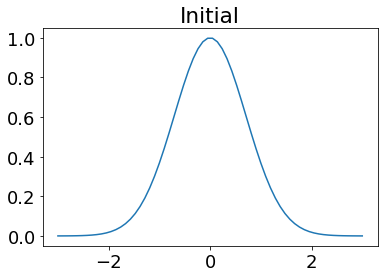

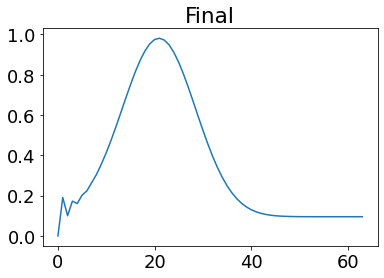

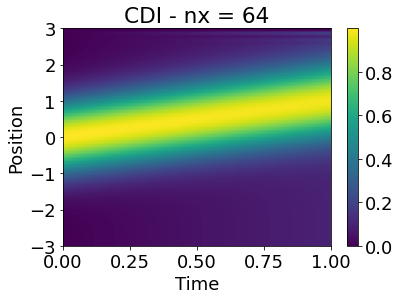

In [137]:
# Performing above with du/dx=0 at both ends
def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
    alpha = a*dt/dx
    beta = b*dt/dx**2
    nx = len(u_CDI)-1;
    A = np.zeros((nx+1, nx+1))
    bi = d*dt+u_CDI;
    for j in range(1, len(u_CDI)-1):

        A[j, j-1] = -(beta-alpha/2)
        A[j, j] = 1+2*beta-c*dt
        A[j, j+1] = -(beta+alpha/2)

    # Applying first order Periodic Boundary Condition
    # A[0, 0]=(1+2*beta)-c*dt;
    # A[0, 1]= (-alpha/2-beta)
    # A[0, nx]= (alpha/2-beta)    


    # A[nx, 0]= (-alpha/2-beta) ;
    # A[nx, nx-1]= (alpha/2 - beta)
    # A[nx, nx]= 1+2*beta-c*dt    


    # Applying second order periodic boundary conditions
    # bt = d*dt+u_CDI;
    # kk = np.zeros(2)
    # bi = [*kk, *bt]

    # A[0, 0]=0;
    # A[0, 1]= 1
    # A[0, N]= -1
    # A[0, N+1]=0

    # A[1, 0] = -1
    # A[1,1] = 0
    # A[1, 2] = 1
    # A[1, N-1] = 1
    # A[1, N] = 0 
    # A[1, N+1] = -1

    N = nx
    # Boundary condition
    # A[0, 0] = -3
    # A[0, 1] = 4
    # A[0, 2] = -1
    # bi[0] = 0

    A[N, N] = 3
    A[N, N-1] = -4
    A[N, N-2] = 1
    bi[N] = 0


    A[0,0] = 1.0
    # A[N,N] = 1.0

    bi[0] = 0.
    # bi[N] = 0


    u_CDI = solve(A, bi)

    return u_CDI

nx = 63
nt= 999
L = 3.0
T = 1.0
N = nx


x = np.linspace(-L, L, nx+1)
t = np.linspace(0, T, nt+1)
# x= np.flip(x, 0)
print(x)
u = np.exp(-x**2)#(((1./6.)*x+(1./2.))**2)*np.sin(np.pi*x)
ui = u;
U_CDI = np.zeros((nx+1, nt+1))
error_2norm_CDI_PSTD = np.zeros(nt+1)

# Discretization of space and time
dx = 2*L/(nx+1)
# dt = 0.1*dx**2/D#T/(nt-1)
# dx = L/(nx+1)
dt = T/(nt+1)

U_CDI = np.zeros((nx+1, nt+1))
error_2norm_QI_PSTD = np.zeros(nt)

u_CDI=ui;
plt.plot(x,ui)
plt.title('Initial')
for n in range(nt+1):
    u_CDI = numerical_scheme_CDI(u_CDI, 1.0, 0.01, -0.1, 0.1, dx, dt)
    U_CDI[:, n] = u_CDI

plt.figure()
plt.plot(u_CDI, label='Final')
plt.title('Final')
#plt.show()
#plt.close()
print(U_CDI[:, -1])
plt.rcParams['font.size'] = 18
fig = plt.figure() 
plt.imshow(U_CDI, cmap='viridis', extent=[0, T, -L, L], aspect='auto')
plt.colorbar()
title = "CDI - nx = "+str(nx+1)
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()


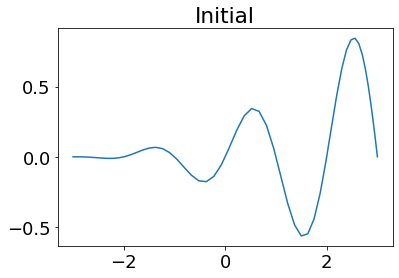

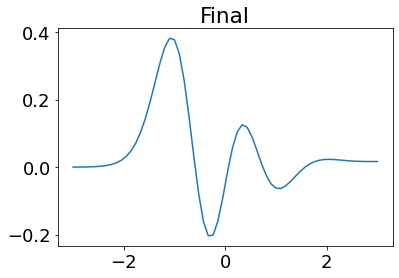

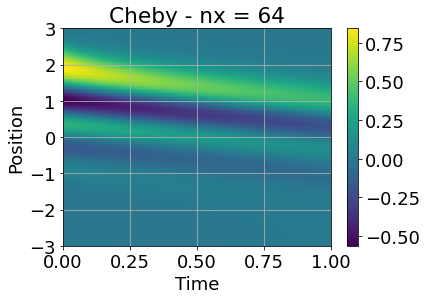

In [134]:
# ==========
# Method 1
# == Output == 
# D: Chebyshev derivative matrix
# x: Chebyshev collocation points
# ==========
def chebDiffMtx(N):
    if N == 0:
        D = 0
        x = 1
    else:
        theta = np.linspace(0,np.pi,num=N+1,endpoint=True).reshape((N+1,1))
        #x = np.cos(theta)
        x = -np.sin(theta-np.pi/2)
        
        c=np.vstack((2,np.ones((N-1,1)),2))*(-1)**np.arange(0,N+1).reshape((N+1,1))
        X = np.tile(x,(1,N+1))
        dX = X-X.T
        # off-diagonal entries
        D = (c@(1/c).T) / (dX+np.eye(N+1))
        D = D-np.diag( np.sum(D,axis=1) )
    return (D,x)
    
def AdvDiffusion(N,dt,T):
    iter_max = int(T/dt)
    # Initialize a (N+1)x(iter_max+1) array to store v(x_i,t_n) 
    V = np.zeros((N+1,iter_max+1))

    # Create the coefficient matrix of the linear system
    [D,x] = chebDiffMtx(N)
    L = 0.1/9 *(D@D)+ 1/3 * D
    L = np.eye(N+1)-dt*L
    A = np.vstack( ( L[1:N,1:N+1] , D[N,1:N+1] ) )

    # Create initial function
    v = 1/4 * ((x+1)**2)* np.sin(3*np.pi*x)
    plt.figure()
    plt.plot(3*x,v)
    plt.title('Initial')
    V[:,0] = v.flatten()

    for k in range(1,iter_max+1):
        # Create the constant term vector of the linear system
        b = np.vstack( ( v[1:N] , 0 ) )     
        # Sovle the linear system
        v = solve(A,b)
        # Add V_0 = 0 to the solution
        v = np.vstack((0,v))

        # Store v to V[:,k]
        V[:,k] = v.flatten()
    
    return V
V1 = AdvDiffusion(63, 0.001, 1.0)
plt.figure()
plt.plot(x,V1[:,-1])
plt.title('Final')
fig = plt.figure()  
plt.imshow((V1), cmap='viridis',  extent=[0, 1., -3, 3], aspect='auto')
plt.colorbar()
plt.title("CD Scheme with Cheby")
plt.xlabel('Time')
plt.ylabel('Position')
title = "Cheby - nx = "+str(63+1)
plt.title(title)
plt.grid(True)
plt.show()
plt.close()

# Pe = 100 without any source terms

# Pe = 100

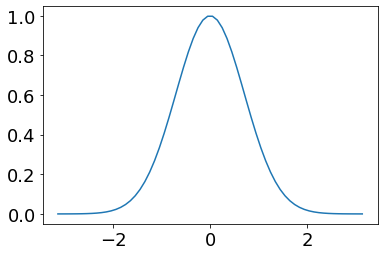

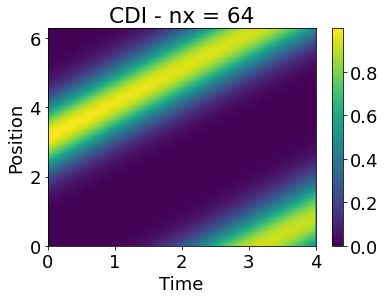

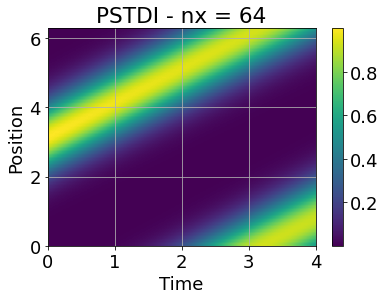

(64,)
(64,)


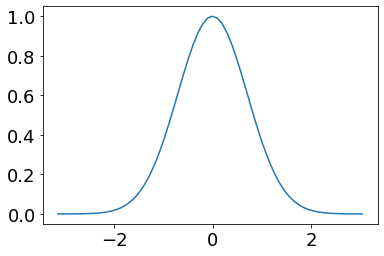

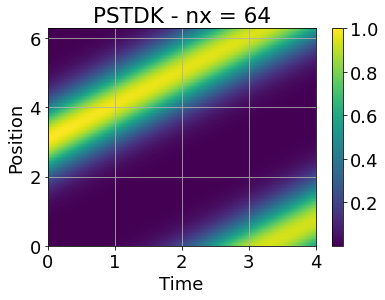

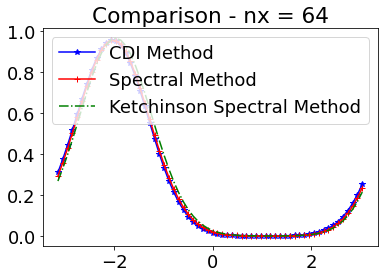

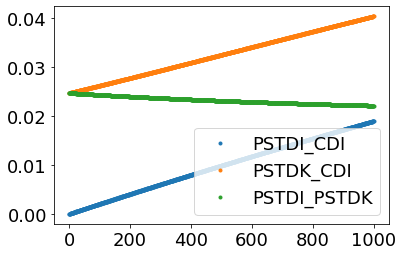

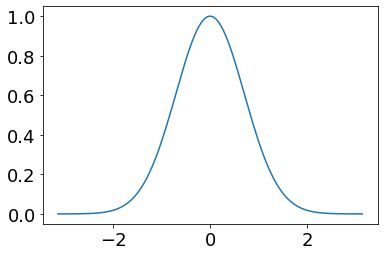

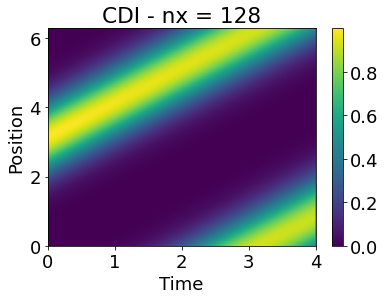

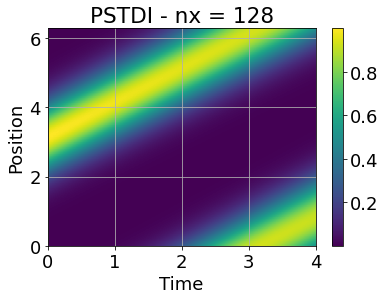

(128,)
(128,)


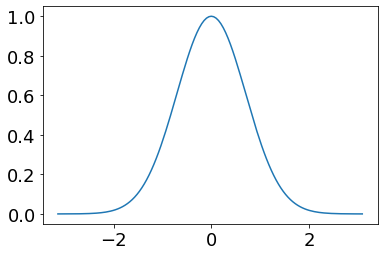

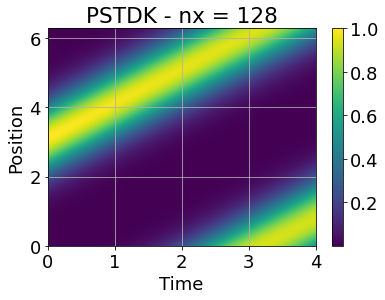

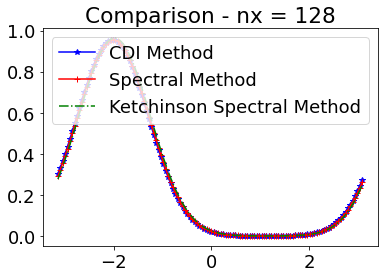

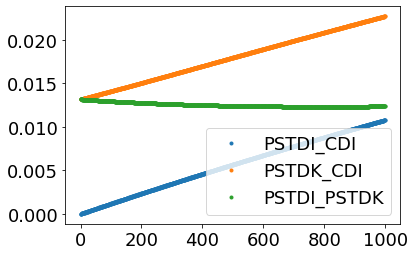

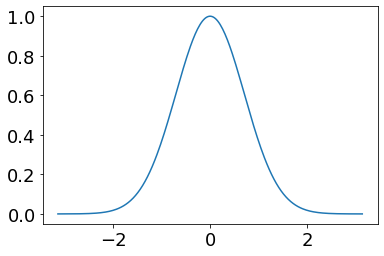

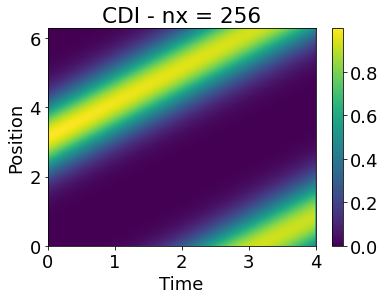

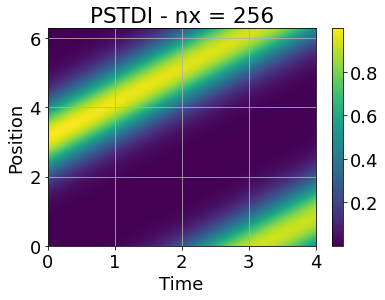

(256,)
(256,)


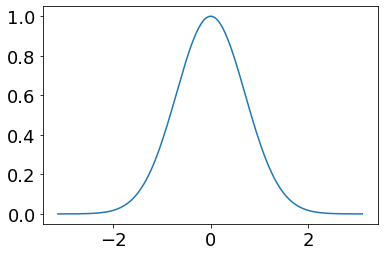

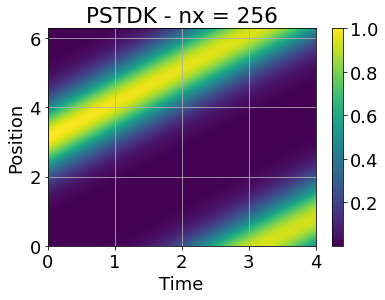

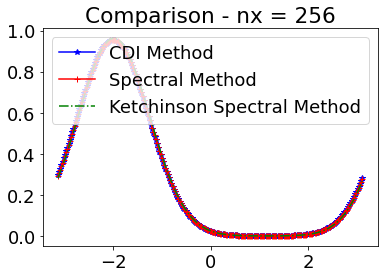

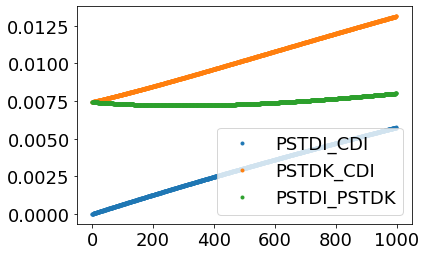

KeyboardInterrupt: 

In [13]:

a = 1.0
b = 0.01
c = 0.0; 
d = 0.0

testAB_PS(a, b, c, d, 63, 1000)
testAB_PS(a, b, c, d, 127, 1000)
res = testAB_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-*', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-+', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-.', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()


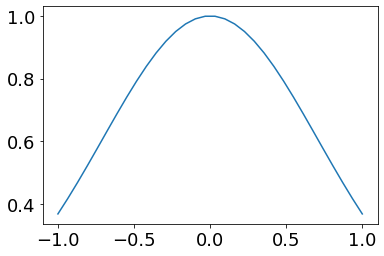

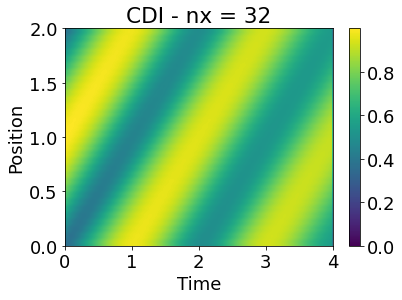

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32,)
(32, 1)
(30,)
[[ 5.00000000e-01 -1.00257194e+00  1.01034087e+00 ... -9.77036766e+01
   3.89812134e+02 -3.20500000e+02]
 [-1.52891151e+00  2.82502715e+00 -3.32368747e-01 ... -3.61195467e-05
   3.59979250e-05 -1.79785629e-05]
 [ 1.69376149e-01 -5.37189851e-01  1.38820446e+00 ...  1.52585509e-03
  -1.51416103e-03  7.55144765e-04]
 ...
 [-1.26351831e-03  2.53365652e-03 -2.55365676e-03 ...  1.29160772e+00
  -1.61774711e-02 -2.58359924e-02]
 [ 1.98516217e-03 -3.98061401e-03  4.01169800e-03 ... -8.53381126e-01
   2.43660601e+00 -7.50066088e-01]
 [ 5.00000000e-01 -1.00257194e+00  1.01034087e+00 ... -9.77036766e+01
   3.89812134e+02 -3.20500000e+02]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:173: LinAlgWarning: Ill-conditioned matrix (rcond=5.32743e-21): result may not be accurate.


323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

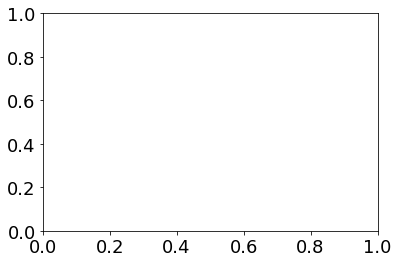

In [63]:

a = 1.0
b = 0.01
c = 0.0; 
d = 0.0

testAB_PSCH(a, b, c, d, 31, 1000)
testAB_PSCH(a, b, c, d, 127, 1000)
res = testAB_PSCH(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-*', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-+', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-.', color = 'g', label = 'Ketchinson Spectral Method');
plt.plot(res[3], '-', color = 'm', label = 'Chebyshev Spectral Method');

plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()


NameError: name 'bs' is not defined

# Pe = 1

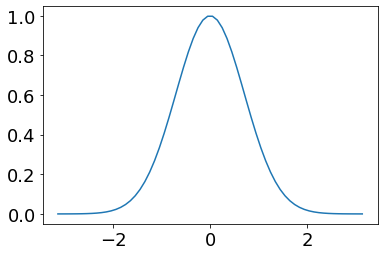

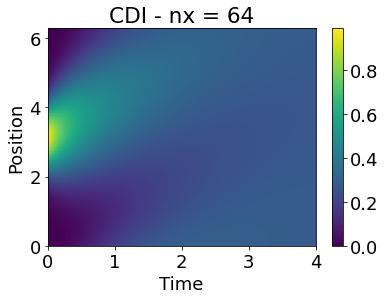

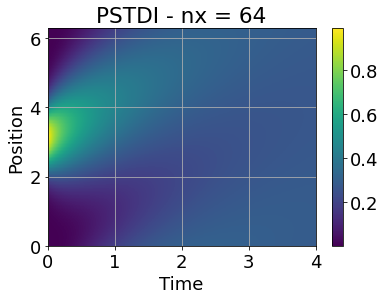

(64,)
(64,)


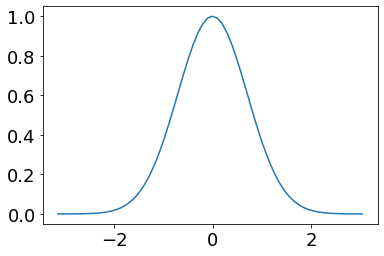

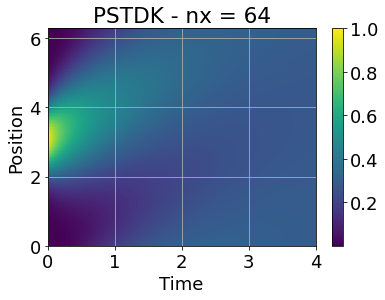

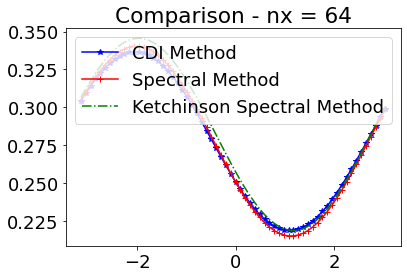

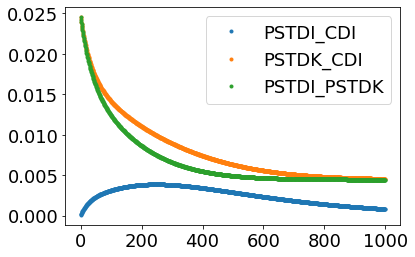

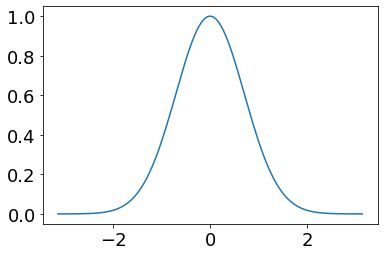

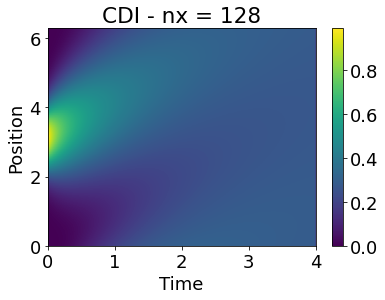

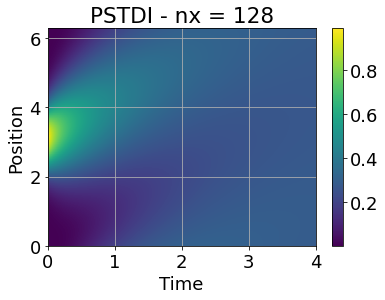

(128,)
(128,)


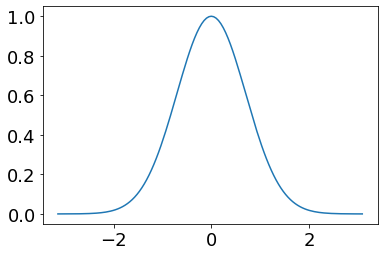

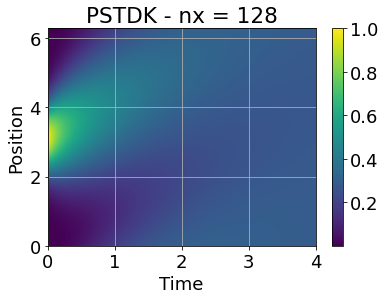

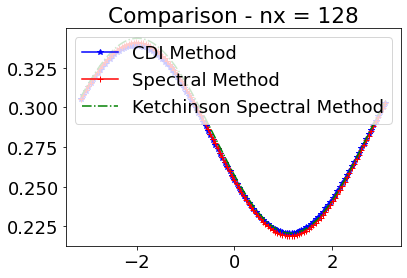

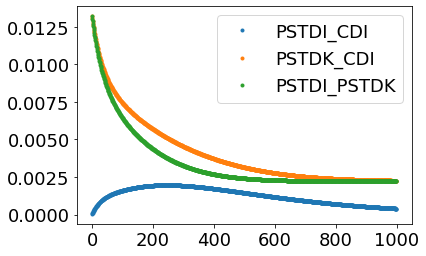

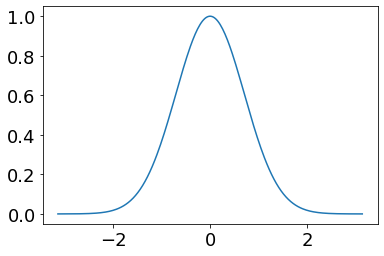

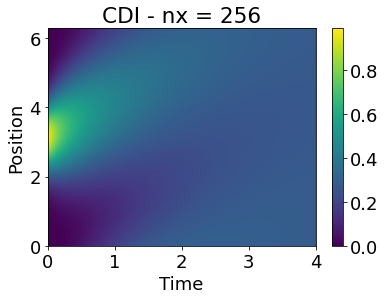

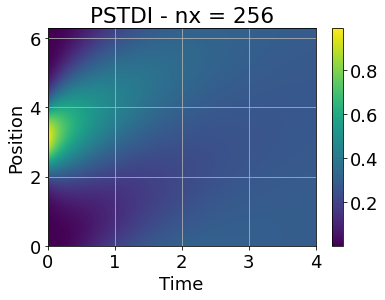

(256,)
(256,)


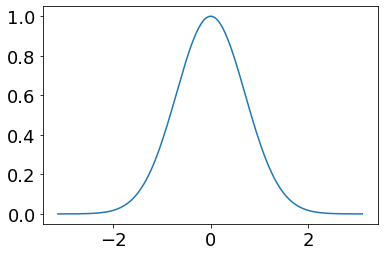

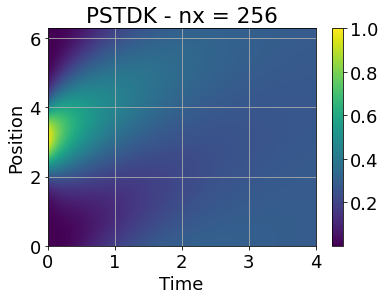

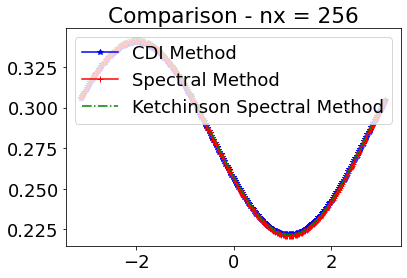

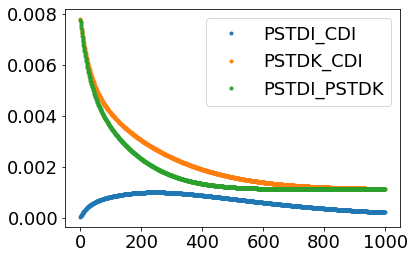

[array([0.28631191, 0.28616154, 0.28600805, 0.28585155, 0.28569211,
        0.28552985, 0.28536484, 0.28519721, 0.28502704, 0.28485444,
        0.28467951, 0.28450236, 0.28432309, 0.28414182, 0.28395865,
        0.28377369, 0.28358706, 0.28339886, 0.28320921, 0.28301822,
        0.28282601, 0.2826327 , 0.2824384 , 0.28224322, 0.28204729,
        0.28185073, 0.28165364, 0.28145616, 0.2812584 , 0.28106047,
        0.2808625 , 0.28066461, 0.28046692, 0.28026954, 0.2800726 ,
        0.27987621, 0.27968049, 0.27948556, 0.27929154, 0.27909854,
        0.27890668, 0.27871607, 0.27852684, 0.27833909, 0.27815293,
        0.27796849, 0.27778587, 0.27760517, 0.27742652, 0.27725001,
        0.27707576, 0.27690386, 0.27673443, 0.27656756, 0.27640335,
        0.27624191, 0.27608333, 0.2759277 , 0.27577512, 0.27562569,
        0.27547948, 0.2753366 , 0.27519712, 0.27506113, 0.27492872,
        0.27479995, 0.27467491, 0.27455368, 0.27443633, 0.27432292,
        0.27421353, 0.27410822, 0.27400706, 0.27

In [150]:

a = 1.0
b = 1.0
c = 0.0; 
d = 0.0

testAB_PS(a, b, c, d, 63, 1000)
testAB_PS(a, b, c, d, 127, 1000)
testAB_PS(a, b, c, d, 255, 1000)

# Pe = 0.1

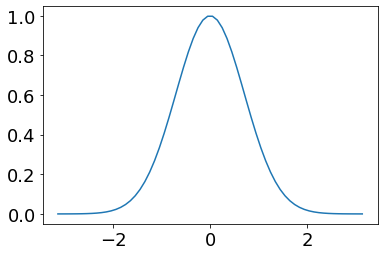

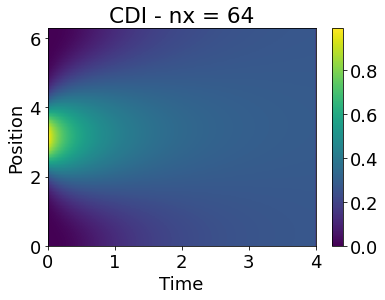

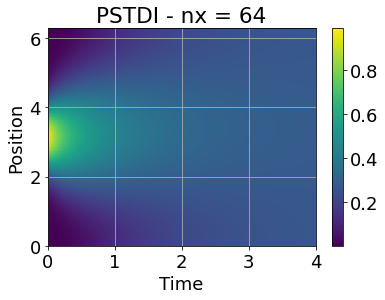

(64,)
(64,)


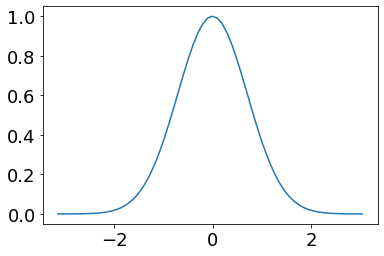

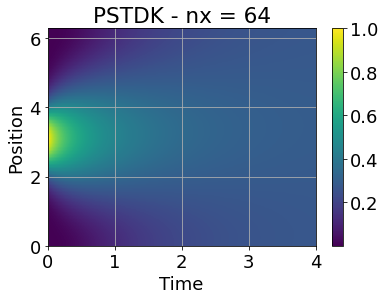

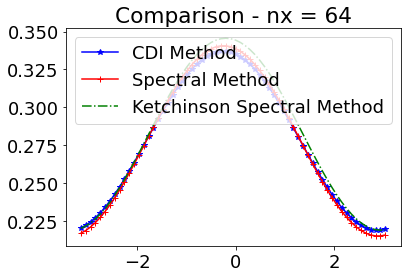

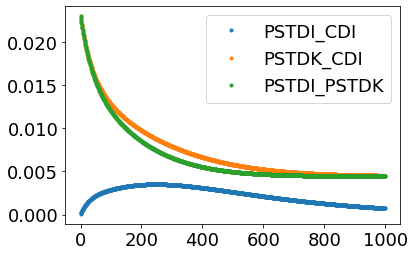

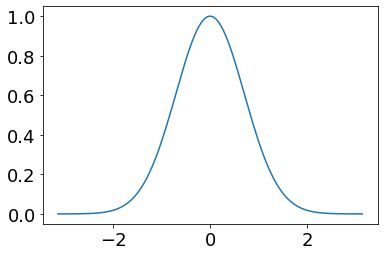

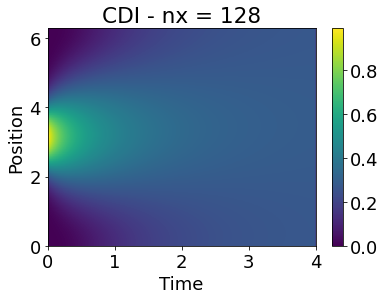

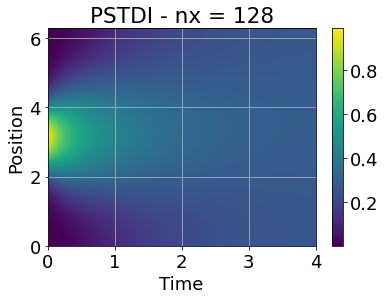

(128,)
(128,)


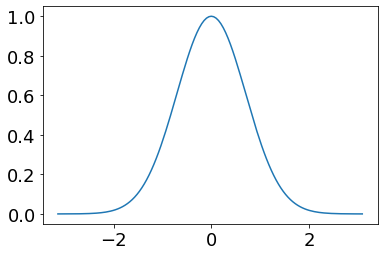

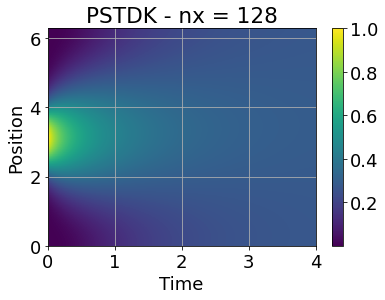

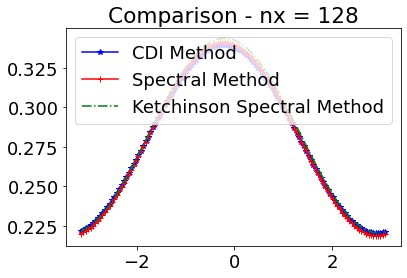

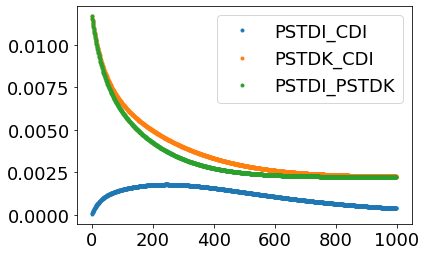

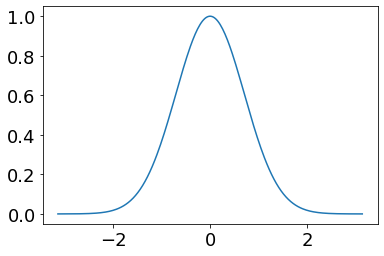

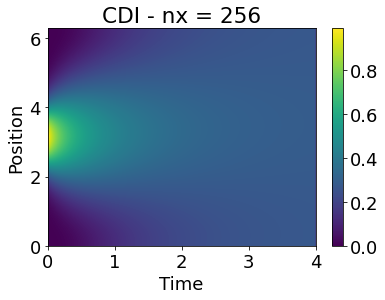

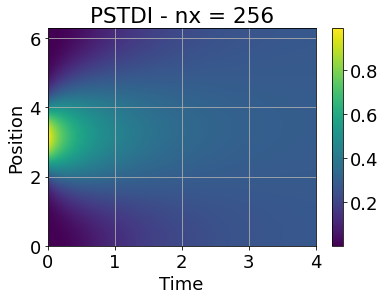

(256,)
(256,)


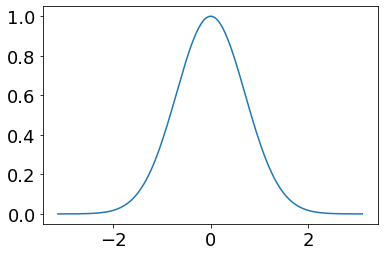

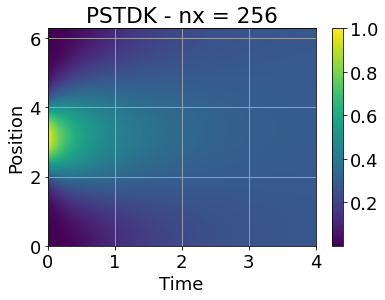

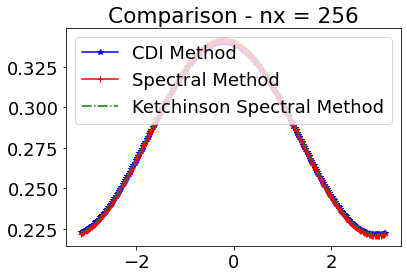

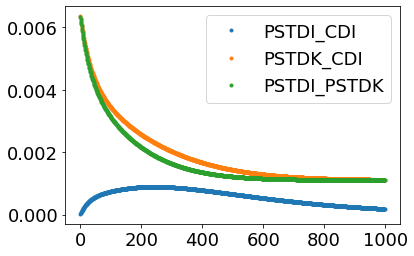

[array([0.27353551, 0.27361733, 0.27370358, 0.27379423, 0.27388921,
        0.27398847, 0.27409195, 0.27419958, 0.2743113 , 0.27442705,
        0.27454675, 0.27467033, 0.27479771, 0.27492883, 0.2750636 ,
        0.27520194, 0.27534377, 0.275489  , 0.27563754, 0.27578931,
        0.2759442 , 0.27610214, 0.27626303, 0.27642676, 0.27659324,
        0.27676237, 0.27693405, 0.27710817, 0.27728462, 0.27746332,
        0.27764413, 0.27782696, 0.2780117 , 0.27819823, 0.27838644,
        0.27857623, 0.27876746, 0.27896004, 0.27915384, 0.27934874,
        0.27954464, 0.2797414 , 0.27993892, 0.28013707, 0.28033574,
        0.2805348 , 0.28073413, 0.28093362, 0.28113314, 0.28133258,
        0.28153181, 0.28173072, 0.28192918, 0.28212707, 0.28232428,
        0.28252069, 0.28271617, 0.28291062, 0.28310391, 0.28329592,
        0.28348655, 0.28367568, 0.28386318, 0.28404896, 0.28423289,
        0.28441487, 0.28459479, 0.28477254, 0.28494801, 0.28512109,
        0.28529169, 0.2854597 , 0.28562501, 0.28

In [151]:

a = 0.1
b = 1.0
c = 0.0; 
d = 0.0

testAB_PS(a, b, c, d, 63, 1000)
testAB_PS(a, b, c, d, 127, 1000)
testAB_PS(a, b, c, d, 255, 1000)

sdeds


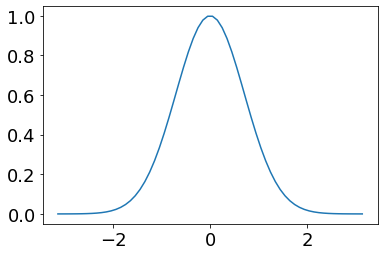

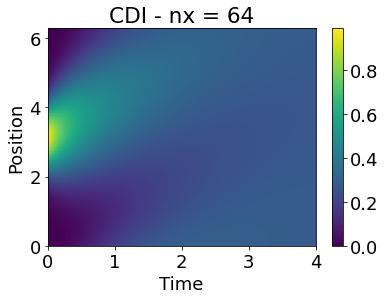

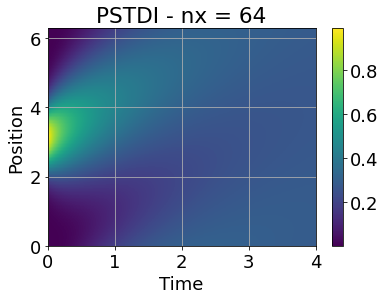

(64,)
(64,)


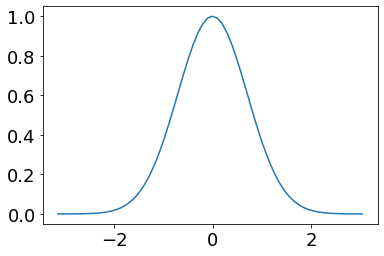

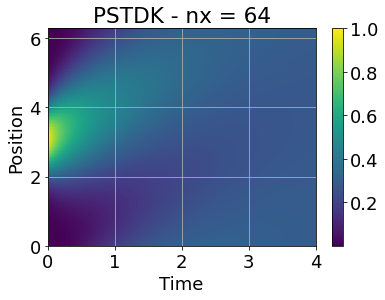

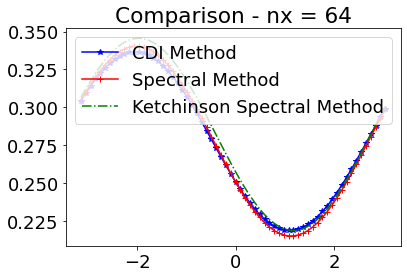

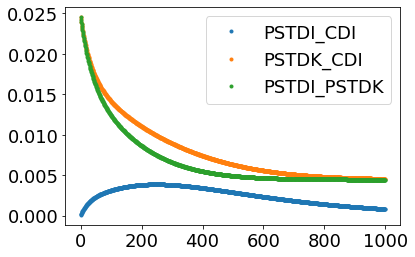

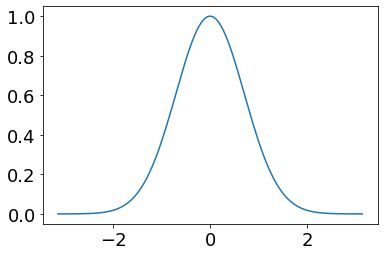

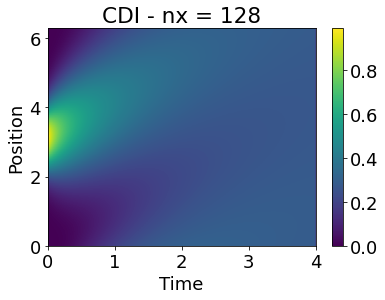

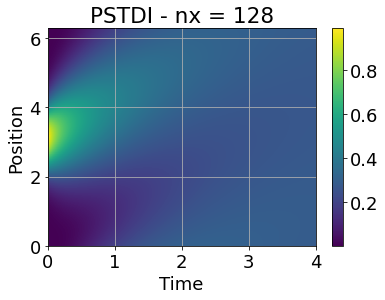

(128,)
(128,)


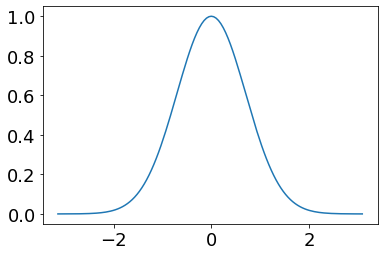

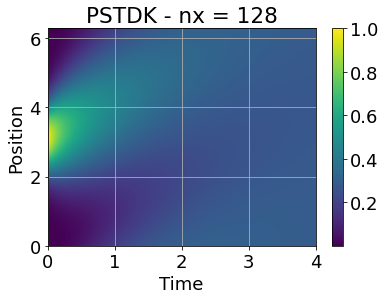

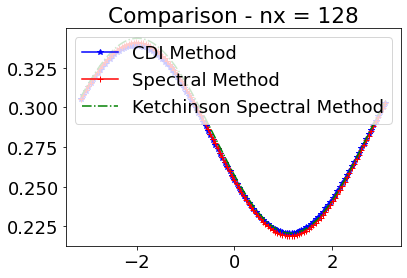

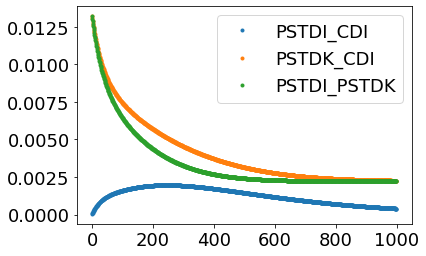

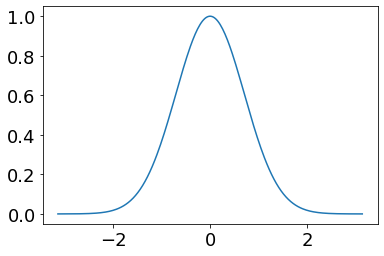

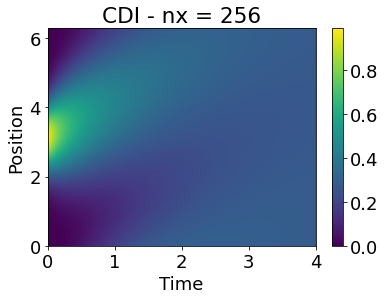

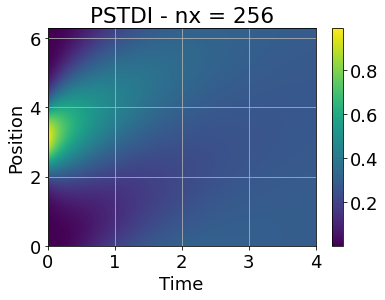

(256,)
(256,)


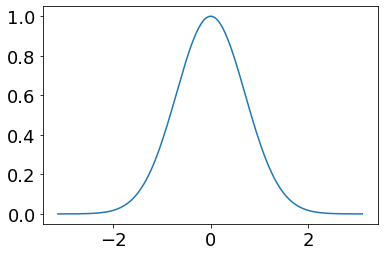

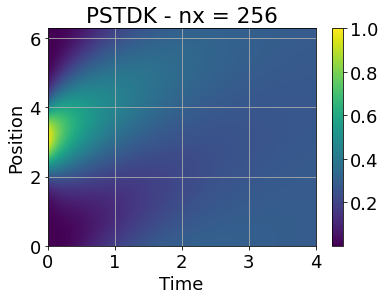

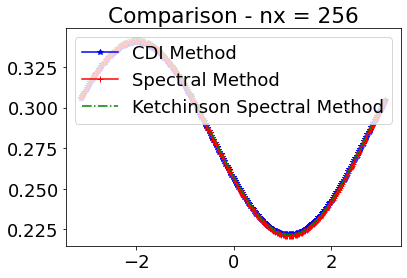

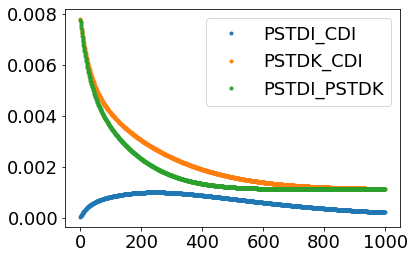

[array([0.28631191, 0.28616154, 0.28600805, 0.28585155, 0.28569211,
        0.28552985, 0.28536484, 0.28519721, 0.28502704, 0.28485444,
        0.28467951, 0.28450236, 0.28432309, 0.28414182, 0.28395865,
        0.28377369, 0.28358706, 0.28339886, 0.28320921, 0.28301822,
        0.28282601, 0.2826327 , 0.2824384 , 0.28224322, 0.28204729,
        0.28185073, 0.28165364, 0.28145616, 0.2812584 , 0.28106047,
        0.2808625 , 0.28066461, 0.28046692, 0.28026954, 0.2800726 ,
        0.27987621, 0.27968049, 0.27948556, 0.27929154, 0.27909854,
        0.27890668, 0.27871607, 0.27852684, 0.27833909, 0.27815293,
        0.27796849, 0.27778587, 0.27760517, 0.27742652, 0.27725001,
        0.27707576, 0.27690386, 0.27673443, 0.27656756, 0.27640335,
        0.27624191, 0.27608333, 0.2759277 , 0.27577512, 0.27562569,
        0.27547948, 0.2753366 , 0.27519712, 0.27506113, 0.27492872,
        0.27479995, 0.27467491, 0.27455368, 0.27443633, 0.27432292,
        0.27421353, 0.27410822, 0.27400706, 0.27

In [152]:

a = 1.0
b = 1.0
c = 0.0
d = 0.0
print("sdeds")
testAB_PS(a, b, c, d, 63, 1000)
testAB_PS(a, b, c, d, 127, 1000)
testAB_PS(a, b, c, d, 255, 1000)

ssfw


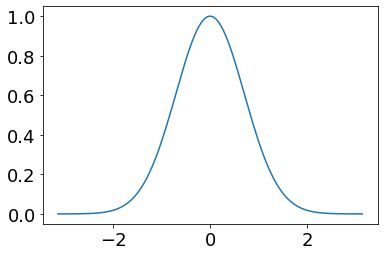

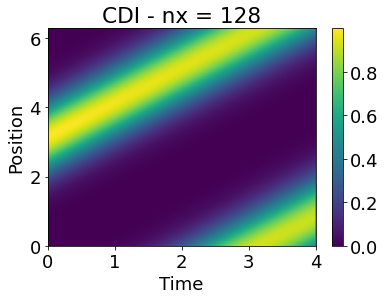

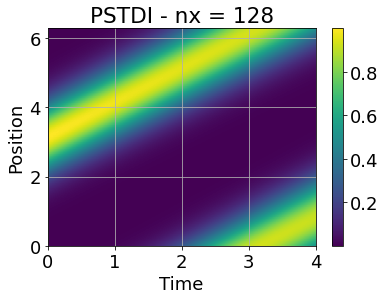

(128,)
(128,)


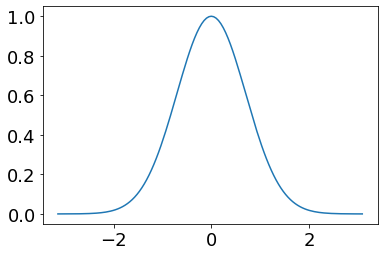

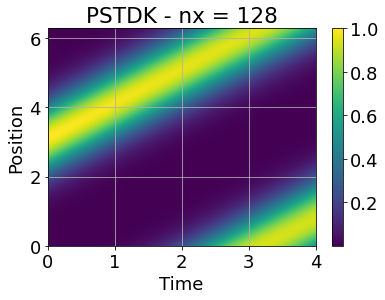

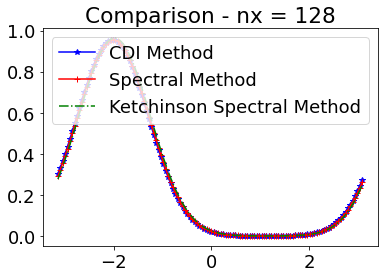

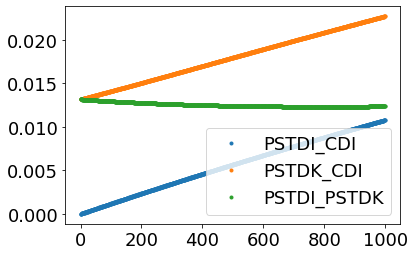

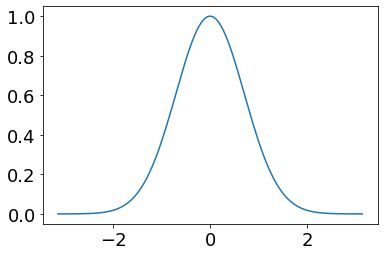

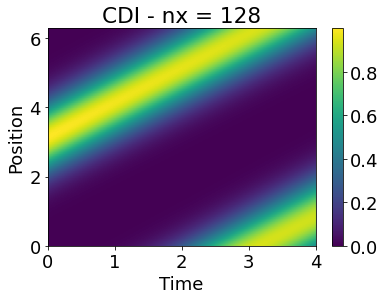

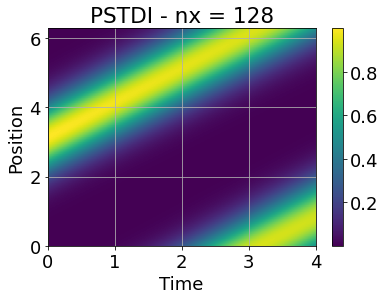

(128,)
(128,)


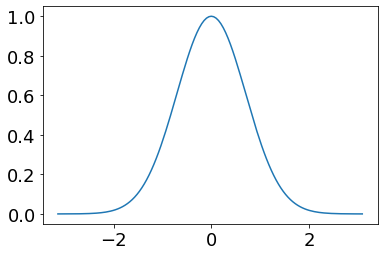

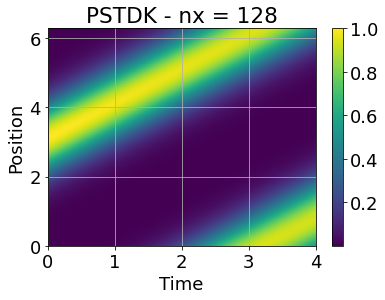

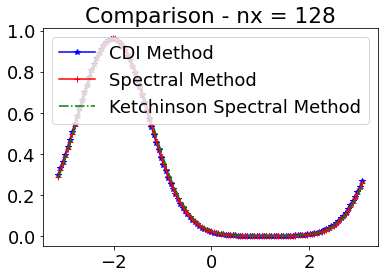

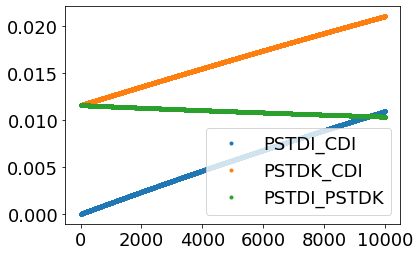

[array([4.73207819e-01, 4.37737562e-01, 4.03181822e-01, 3.69751986e-01,
        3.37628998e-01, 3.06962852e-01, 2.77872745e-01, 2.50447854e-01,
        2.24748650e-01, 2.00808665e-01, 1.78636642e-01, 1.58218964e-01,
        1.39522280e-01, 1.22496241e-01, 1.07076276e-01, 9.31863210e-02,
        8.07414596e-02, 6.96504053e-02, 5.98177967e-02, 5.11462708e-02,
        4.35382942e-02, 3.68977425e-02, 3.11312252e-02, 2.61491609e-02,
        2.18666156e-02, 1.82039183e-02, 1.50870761e-02, 1.24480099e-02,
        1.02246347e-02, 8.36080878e-03, 6.80617670e-03, 5.51592684e-03,
        4.45048654e-03, 3.57517306e-03, 2.85981769e-03, 2.27837773e-03,
        1.80854860e-03, 1.43138628e-03, 1.13094819e-03, 8.93958455e-04,
        7.09502197e-04, 5.68751831e-04, 4.64727408e-04, 3.92092153e-04,
        3.46983810e-04, 3.26882102e-04, 3.30512466e-04, 3.57786210e-04,
        4.09777300e-04, 4.88735962e-04, 5.98139245e-04, 7.42778492e-04,
        9.28883270e-04, 1.16428089e-03, 1.45858998e-03, 1.823445

In [153]:

a = 1.0
b = 0.01
c = 0.0; 
d = 0.0
print("ssfw")
testAB_PS(a, b, c, d, 127, 1000)
testAB_PS(a, b, c, d, 127, 10000)

## With First Order Term 

In [154]:
def testABC_PS(a, b, c, d, nx, nt):

    L = np.pi
    T = 4.0


    x = np.linspace(-L, L, nx+1)
    t = np.linspace(0, T, nt+1)
    
    u = np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)

    # Discretization of space and time
    dx = 2*L/(nx+1)
    # dt = 0.1*dx**2/D#T/(nt-1)
    # dx = L/(nx+1)
    dt = T/(nt+1)


    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = a*dt/dx
        beta = b*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt    


        # Applying second order periodic boundary conditions
        # bt = d*dt+u_CDI;
        # kk = np.zeros(2)
        # bi = [*kk, *bt]

        # A[0, 0]=0;
        # A[0, 1]= 1
        # A[0, N]= -1
        # A[0, N+1]=0

        # A[1, 0] = -1
        # A[1,1] = 0
        # A[1, 2] = 1
        # A[1, N-1] = 1
        # A[1, N] = 0 
        # A[1, N+1] = -1


        # Boundary condition
        # A[0, 0] = -3
        # A[0, 1] = 4
        # A[0, 2] = -1
        # bi[0] = 0

        # A[N, N] = 3
        # A[N, N-1] = -4
        # A[N, N-2] = 1
        # bi[N] = 0


        # A[0,0] = 1.0
        # # A[N,N] = 1.0

        # bi[0] = l
        # bi[N] = r


        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    # u = np.exp(-((x+0.5)**2)/(0.00125))
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_QI_PSTD = np.zeros(nt)

    u_CDI=u;
    plt.plot(x,u)
    for n in range(nt):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt)
        U_CDI[:, n] = u_CDI

    #plt.plot(u_CDI, label='Final')
    #plt.show()
    #plt.close()

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()


    k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    k2=k**2;

    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))
    U_psk = np.zeros((nx+1, nt+1))
    #plt.figure()
    #plt.plot(xin, u, color = 'b', label = "initial")
    # left = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(0.5 - t)**2)/(0.00125 + 0.04*t)))
    # right = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(1.5 - t)**2)/(0.00125 + 0.04*t)))

    # Solving over time
    for i in range(nt+1): # 
        
        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-b*k**2 + a*1j*k+c)*dt) 
        # print(np.shape(uk))    
        u = np.fft.irfft(uk) #+ d*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)


    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    U_psk = np.zeros((nx+1, nt+1))
    error_2norm_PSTDI_PSTDK = np.zeros(nt+1)
    
    error_2norm_CDI_PSTDK = np.zeros(nt+1)
    # Spatial grid
    m=nx+1                            # Number of grid points in space
    L = np.pi                   # Width of spatial domain
    x = np.arange(-m/2,m/2)*(2*L/m)   # Grid points
    dx = x[1]-x[0]                  # Grid spacing

    # Temporal grid
    tmax=T     # Final time
    N = nt+1       # number grid points in time
    dt = tmax/N   # interval between output times

    xi = np.fft.fftfreq(m)*m*np.pi/L  # Wavenumber "grid"
    xi = 2*np.pi*np.fft.fftfreq(nx+1, 2*L/(nx))
    
    # k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    
    
    # (this is the order in which numpy's FFT gives the frequencies)

    # Initial data
    u = np.exp(-x**2)# np.sin(2*x)**2 * (x<-L/4)
    uhat0 = np.fft.fft(u)
    plt.plot(x,u)
    epsilon=b  # Diffusion coefficient
    # a = 1.0       # Advection coefficient

    print(np.shape(xi))
    print(np.shape(u))
    # Now we solve the problem
    for i in range(0,N):
        t = i*dt
        uhat = np.exp((1.j*xi*a - epsilon*xi**2+c)*t) * uhat0
        u = np.real(np.fft.ifft(uhat)) #+ d*t
        
        U_psk[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)
        error =  U_ps[:, i] - u
        error_2norm_PSTDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)

    
    fig = plt.figure()  
    plt.imshow((U_psk), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTDK")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDK - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    plt.figure();
    # plt.plot(x, ui, '-', color='g', label = 'Initial'); 
    plt.plot(x, U_CDI[:, int(nt/2)], '-', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, int(nt/2)], '-', color = 'r', label = 'Spectral Method');
    plt.plot(x, U_psk[:, int(nt/2)+1], '-', color = 'g', label = 'Ketchinson Spectral Method');
    
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1], U_psk[:, nt]]
    
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    
    plt.plot(error_2norm_CDI_PSTDK[0:nt], '.', label = 'PSTDK_CDI')
    
    plt.plot(error_2norm_PSTDI_PSTDK[0:nt], '.', label = 'PSTDI_PSTDK')
    plt.legend()
    plt.show()
    plt.close()
    return res

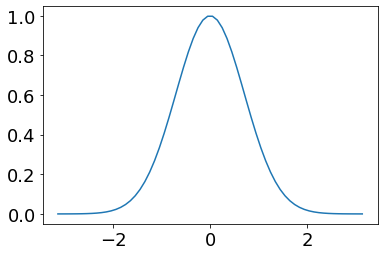

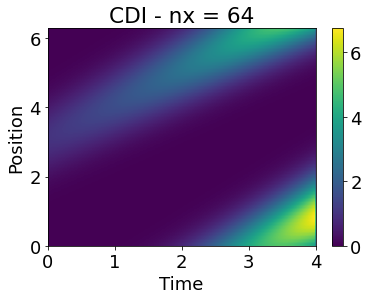

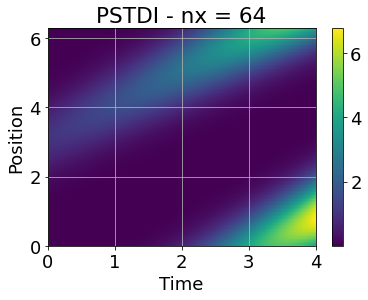

(64,)
(64,)


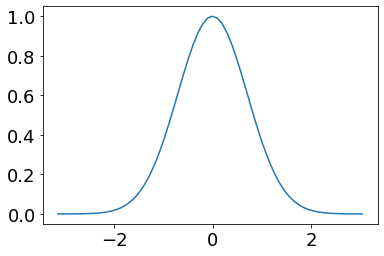

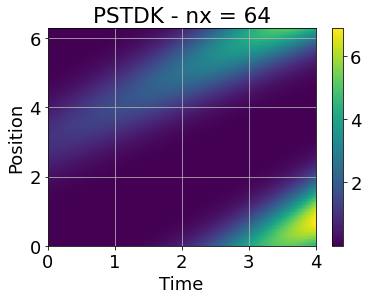

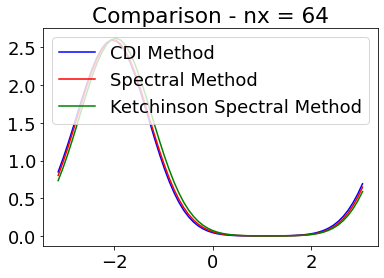

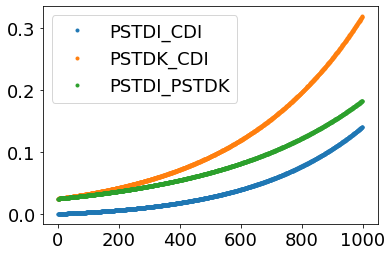

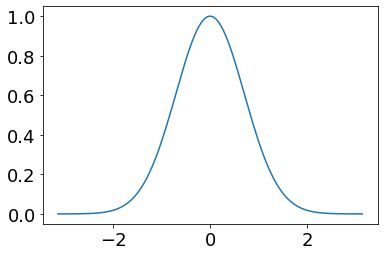

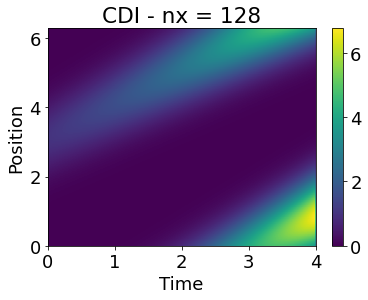

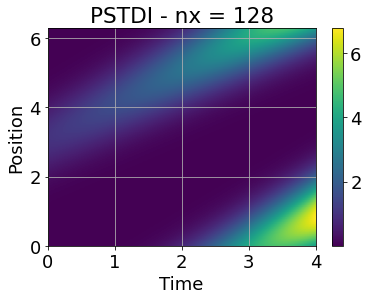

(128,)
(128,)


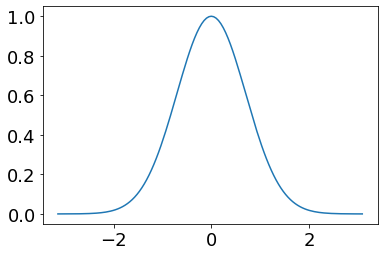

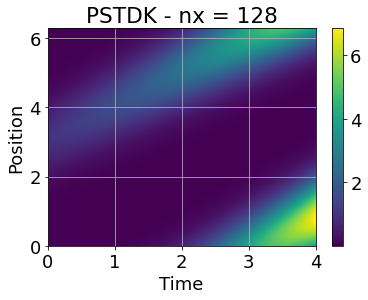

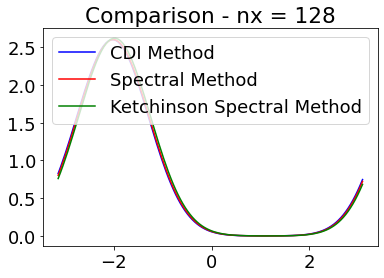

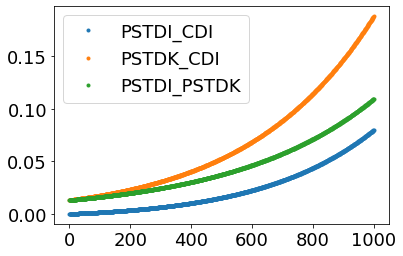

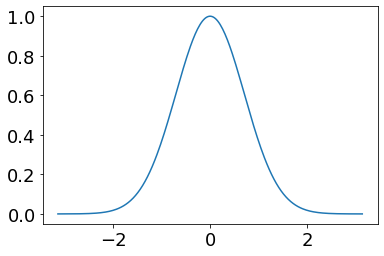

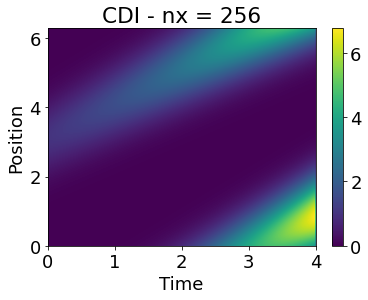

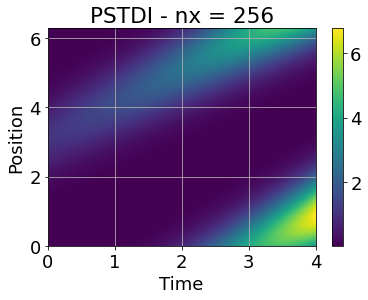

(256,)
(256,)


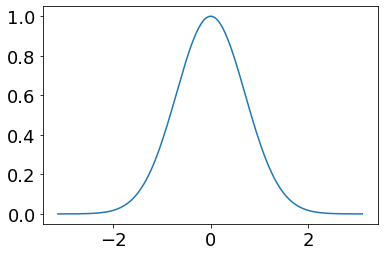

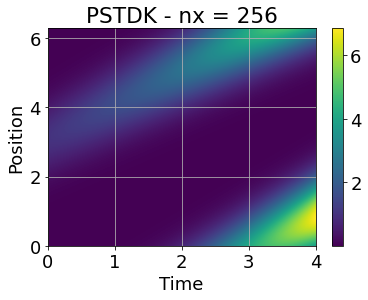

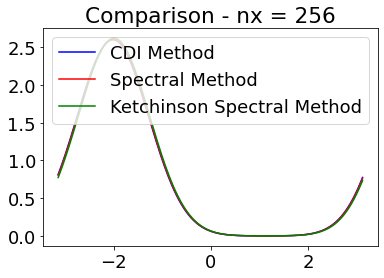

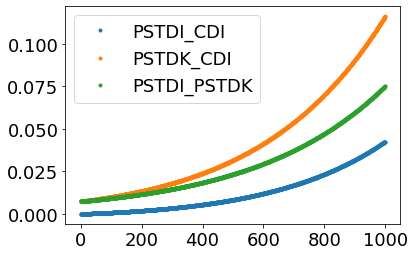

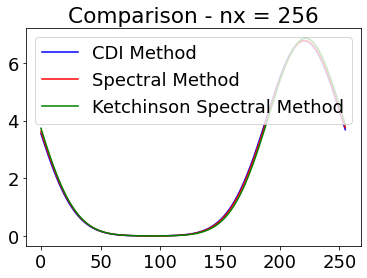

In [155]:

a = 1.0
b = 0.01
c = 0.5; 
d = 0.0

testABC_PS(a, b, c, d, 63, 1000)
testABC_PS(a, b, c, d, 127, 1000)
res = testABC_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()


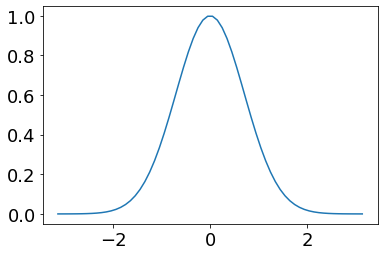

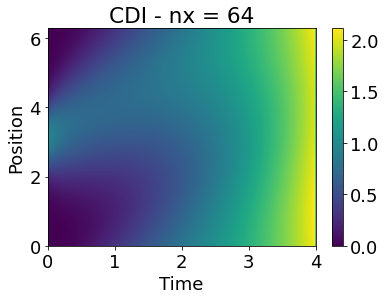

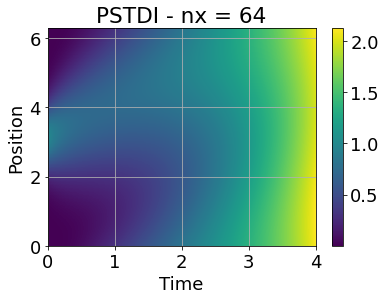

(64,)
(64,)


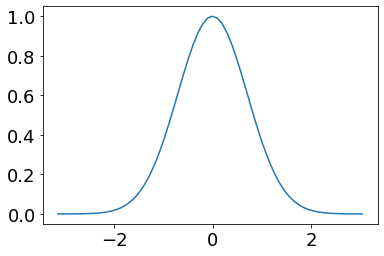

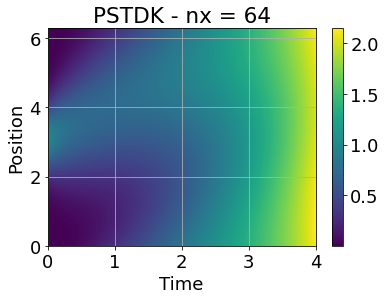

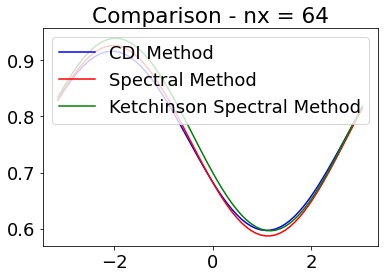

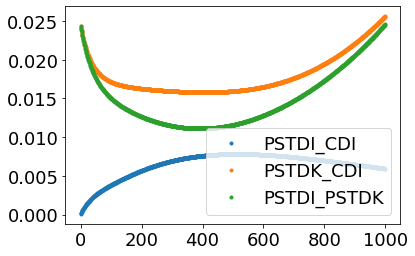

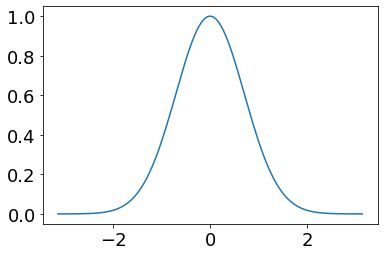

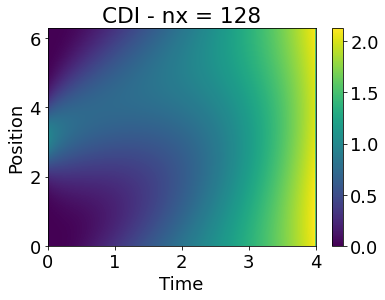

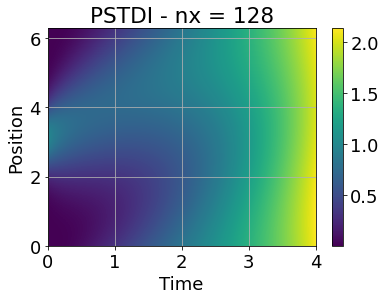

(128,)
(128,)


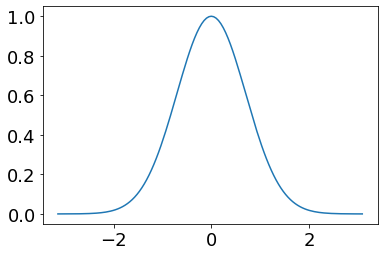

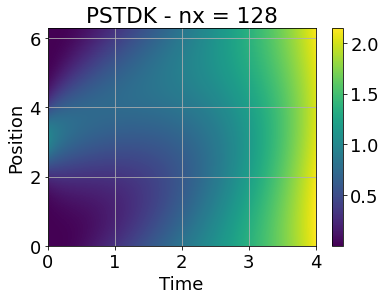

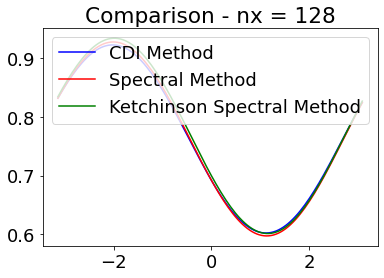

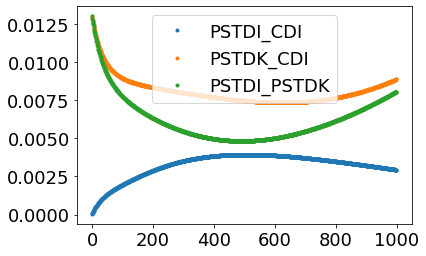

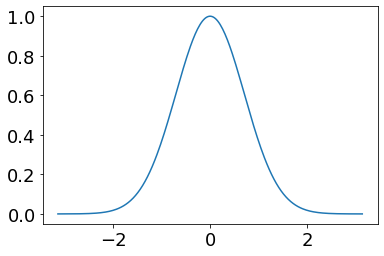

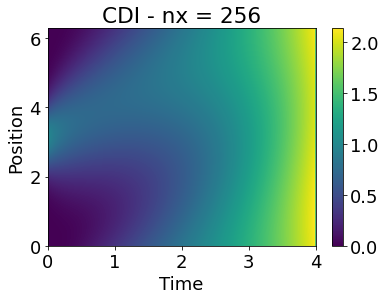

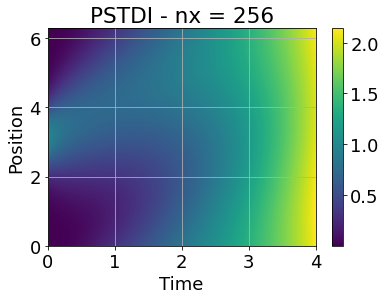

(256,)
(256,)


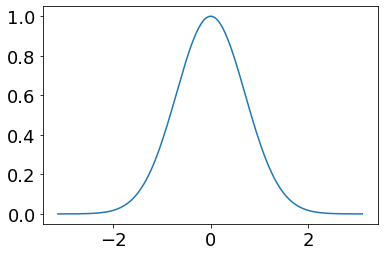

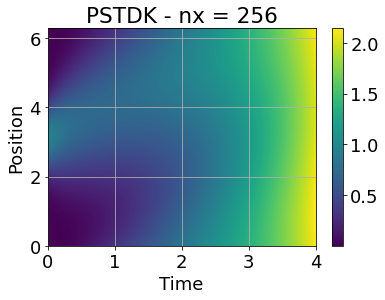

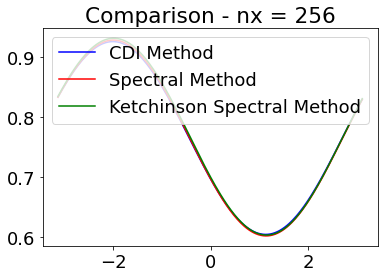

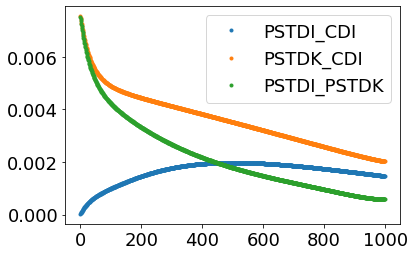

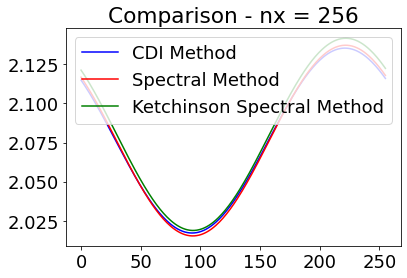

In [156]:

a = 1.0
b = 1.0
c = 0.5; 
d = 0.0

testABC_PS(a, b, c, d, 63, 1000)
testABC_PS(a, b, c, d, 127, 1000)
res = testABC_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()

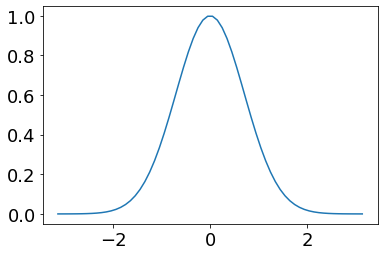

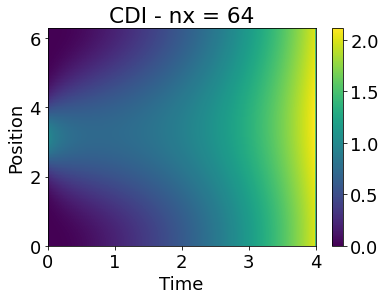

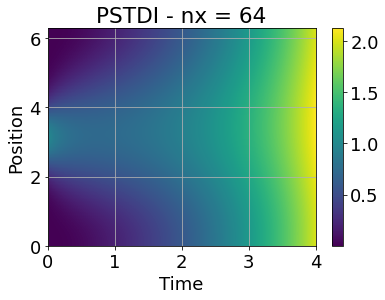

(64,)
(64,)


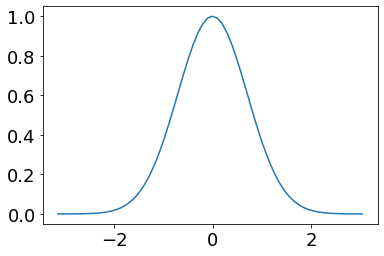

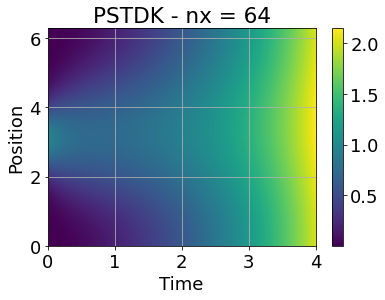

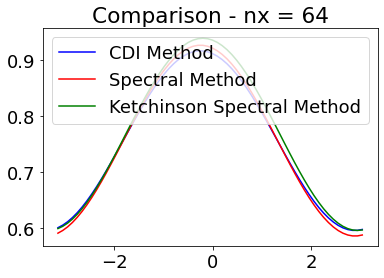

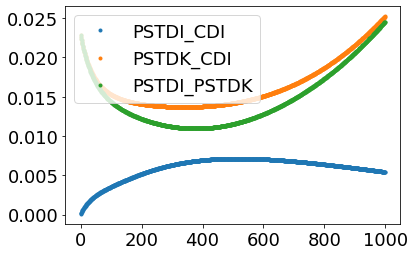

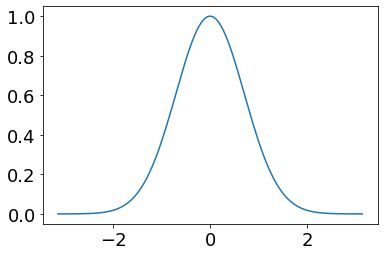

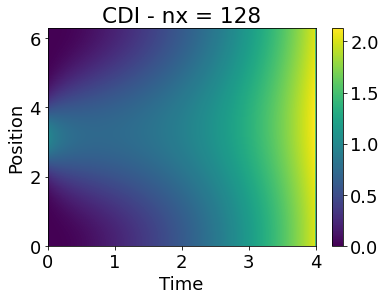

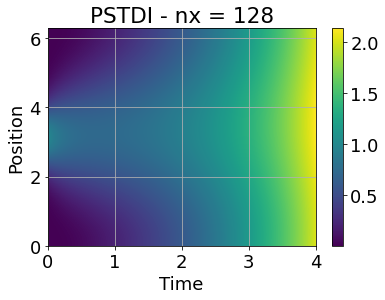

(128,)
(128,)


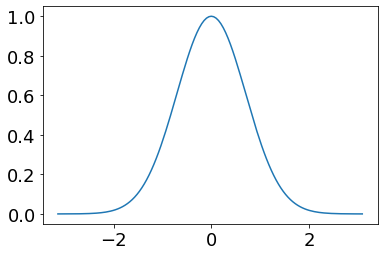

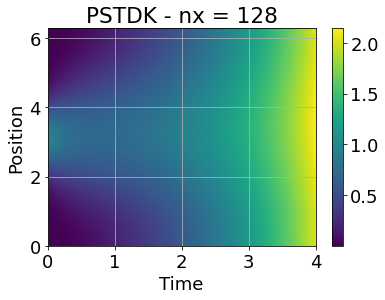

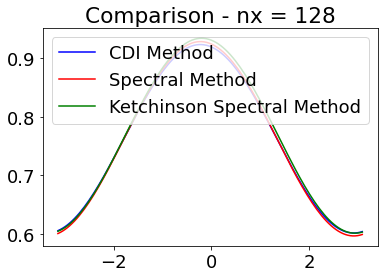

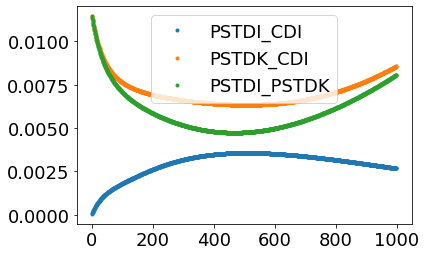

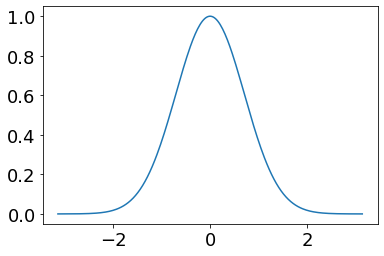

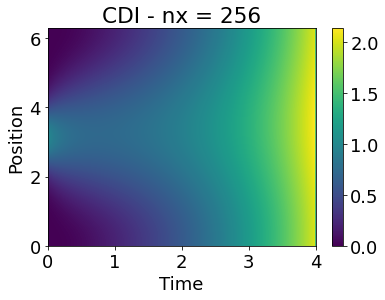

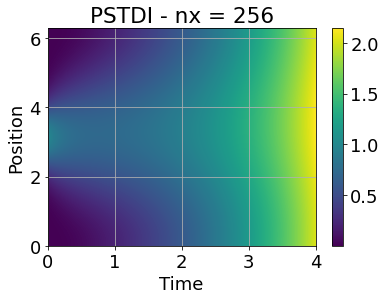

(256,)
(256,)


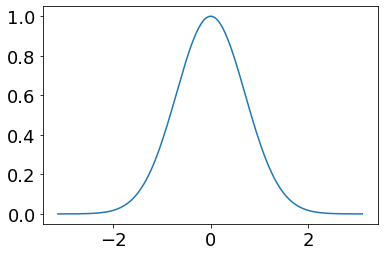

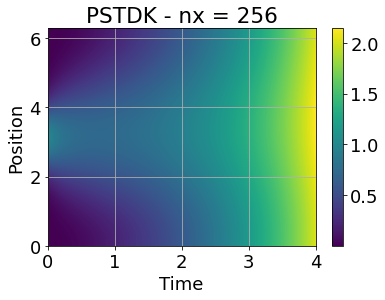

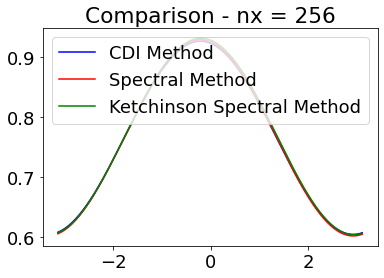

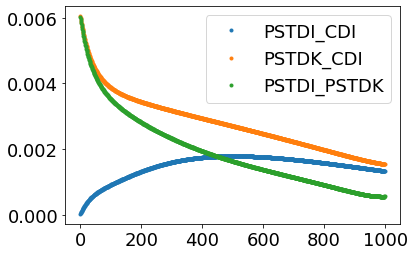

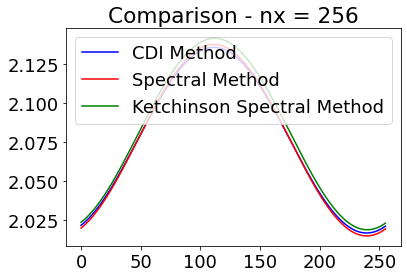

In [157]:

a = 0.1
b = 1.0
c = 0.5; 
d = 0.0

testABC_PS(a, b, c, d, 63, 1000)
testABC_PS(a, b, c, d, 127, 1000)
res = testABC_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()

## With Zeroth and First Order Terms

In [158]:
def test_PS(a, b, c, d, nx, nt):

    L = np.pi
    T = 4.0


    x = np.linspace(-L, L, nx+1)
    t = np.linspace(0, T, nt+1)
    
    u = np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)

    # Discretization of space and time
    dx = 2*L/(nx+1)
    # dt = 0.1*dx**2/D#T/(nt-1)
    # dx = L/(nx+1)
    dt = T/(nt+1)


    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = a*dt/dx
        beta = b*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt    


        # Applying second order periodic boundary conditions
        # bt = d*dt+u_CDI;
        # kk = np.zeros(2)
        # bi = [*kk, *bt]

        # A[0, 0]=0;
        # A[0, 1]= 1
        # A[0, N]= -1
        # A[0, N+1]=0

        # A[1, 0] = -1
        # A[1,1] = 0
        # A[1, 2] = 1
        # A[1, N-1] = 1
        # A[1, N] = 0 
        # A[1, N+1] = -1


        # Boundary condition
        # A[0, 0] = -3
        # A[0, 1] = 4
        # A[0, 2] = -1
        # bi[0] = 0

        # A[N, N] = 3
        # A[N, N-1] = -4
        # A[N, N-2] = 1
        # bi[N] = 0


        # A[0,0] = 1.0
        # # A[N,N] = 1.0

        # bi[0] = l
        # bi[N] = r


        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    # u = np.exp(-((x+0.5)**2)/(0.00125))
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_QI_PSTD = np.zeros(nt)

    u_CDI=u;
    plt.plot(x,u)
    for n in range(nt):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt)
        U_CDI[:, n] = u_CDI

    #plt.plot(u_CDI, label='Final')
    #plt.show()
    #plt.close()

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()


    k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    k2=k**2;

    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))
    U_psk = np.zeros((nx+1, nt+1))
    #plt.figure()
    #plt.plot(xin, u, color = 'b', label = "initial")
    # left = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(0.5 - t)**2)/(0.00125 + 0.04*t)))
    # right = (0.025/(np.sqrt(0.000625 + 0.02*t)))*(np.exp((-(1.5 - t)**2)/(0.00125 + 0.04*t)))

    # Solving over time
    for i in range(nt+1): # 
        
        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-b*k**2 + a*1j*k+c)*dt) 
        # print(np.shape(uk))    
        u = np.fft.irfft(uk) + d*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)


    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    U_psk = np.zeros((nx+1, nt+1))
    error_2norm_PSTDI_PSTDK = np.zeros(nt+1)
    
    error_2norm_CDI_PSTDK = np.zeros(nt+1)
    # Spatial grid
    m=nx+1                            # Number of grid points in space
    L = np.pi                   # Width of spatial domain
    x = np.arange(-m/2,m/2)*(2*L/m)   # Grid points
    dx = x[1]-x[0]                  # Grid spacing

    # Temporal grid
    tmax=T     # Final time
    N = nt+1       # number grid points in time
    dt = tmax/N   # interval between output times

    xi = np.fft.fftfreq(m)*m*np.pi/L  # Wavenumber "grid"
    xi = 2*np.pi*np.fft.fftfreq(nx+1, 2*L/(nx))
    
    # k = 2*np.pi*np.fft.rfftfreq(nx+1, 2*L/(nx))
    
    
    # (this is the order in which numpy's FFT gives the frequencies)

    # Initial data
    u = np.exp(-x**2)# np.sin(2*x)**2 * (x<-L/4)
    uhat0 = np.fft.fft(u)
    plt.plot(x,u)
    epsilon=b  # Diffusion coefficient
    # a = 1.0       # Advection coefficient

    # print(np.shape(xi))
    # print(np.shape(u))
    # Now we solve the problem
    d = np.ones(len(xi))*d
    dfft = np.fft.fft(d)
    # print(dfft)
    # print((dfft/((1.j*xi*a - epsilon*xi**2+c)+1.j*xi)))
    for i in range(0,N):
        t = i*dt
        al = uhat0 + dfft/((1.j*xi*a - epsilon*xi**2+c)+1.j*xi)
        uhat = np.exp((1.j*xi*a - epsilon*xi**2+c)*t) * al-(dfft/((1.j*xi*a - epsilon*xi**2+c)+1.j*xi))
        u = np.real(np.fft.ifft(uhat)) 
        
        U_psk[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)
        error =  U_ps[:, i] - u
        error_2norm_PSTDI_PSTDK[i] =np.linalg.norm(error)/np.sqrt(nx)

    
    plt.figure()  
    plt.imshow((U_psk), cmap='viridis',  extent=[0, T, 0, 2*L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTDK")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDK - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    plt.figure();
    # plt.plot(x, ui, '-', color='g', label = 'Initial'); 
    plt.plot(x, U_CDI[:, int(nt/2)], '-', color='b', label = 'CDI'); 
    plt.plot(x, U_ps[:, int(nt/2)], '-', color = 'r', label = 'PSI');
    plt.plot(x, U_psk[:, int(nt/2)+1], '-', color = 'g', label = 'KPS');
    
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1], U_psk[:, nt]]
    
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    
    plt.plot(error_2norm_CDI_PSTDK[0:nt], '.', label = 'PSTDK_CDI')
    
    plt.plot(error_2norm_PSTDI_PSTDK[0:nt], '.', label = 'PSTDI_PSTDK')
    plt.legend()
    plt.show()
    plt.close()
    return res

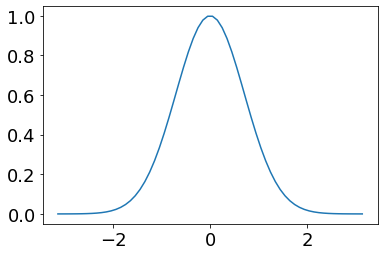

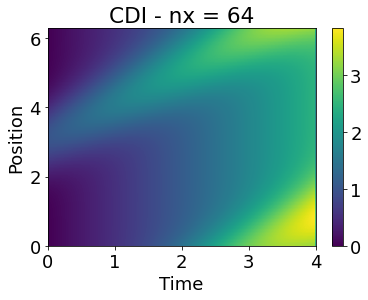

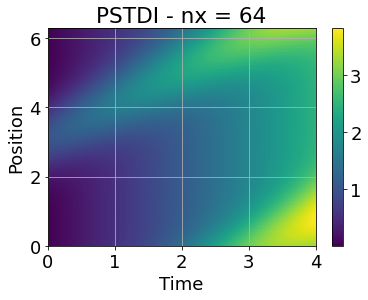

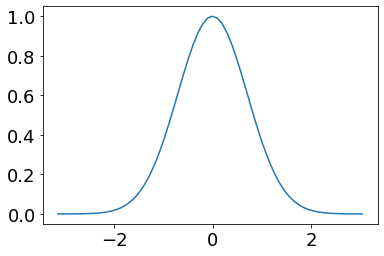

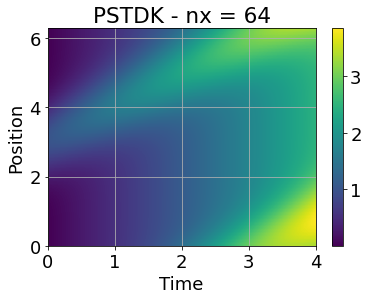

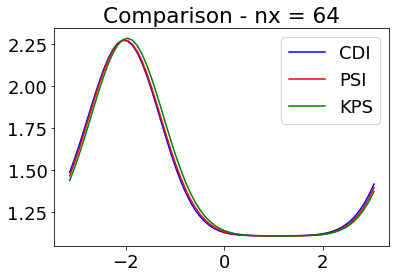

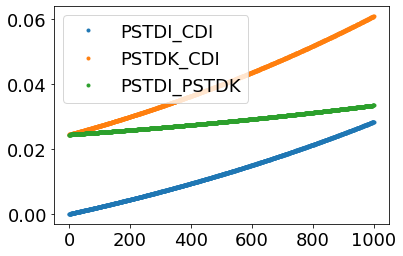

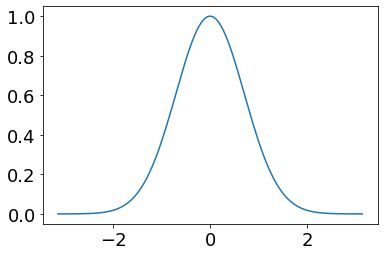

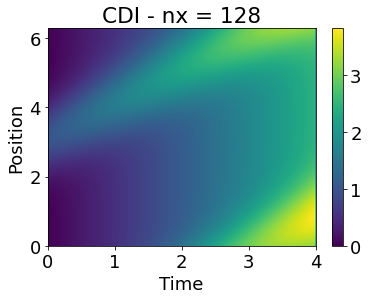

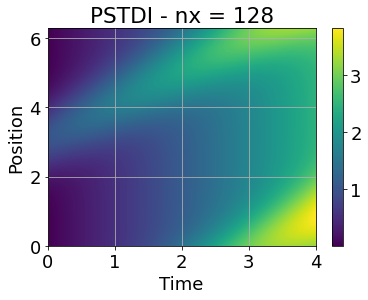

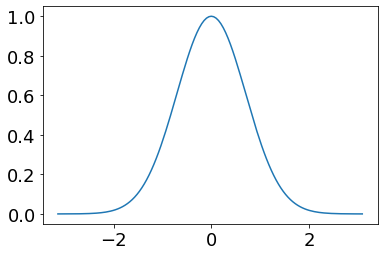

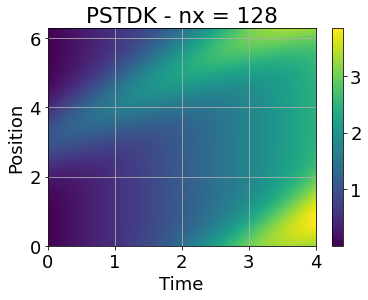

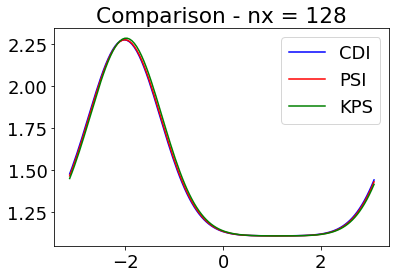

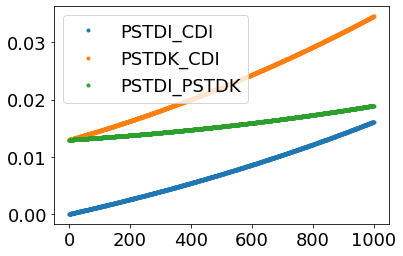

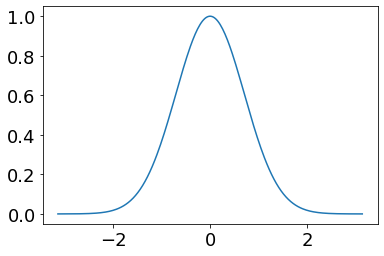

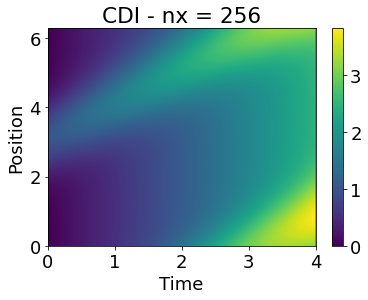

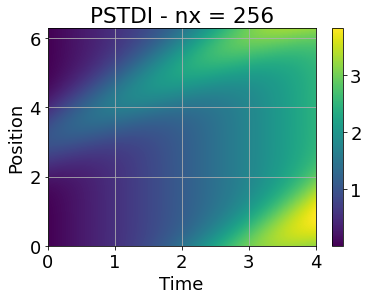

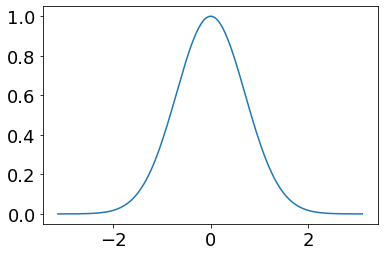

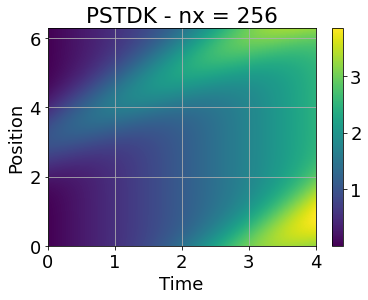

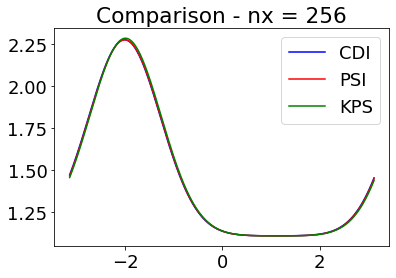

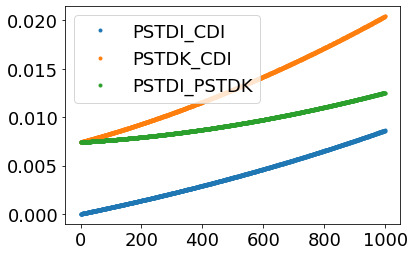

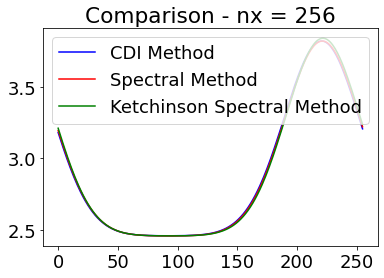

In [159]:

a = 1.0
b = 0.01
c = 0.1; 
d = 0.5

test_PS(a, b, c, d, 63, 1000)
test_PS(a, b, c, d, 127, 1000)
res = test_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()


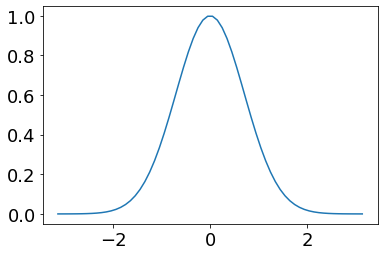

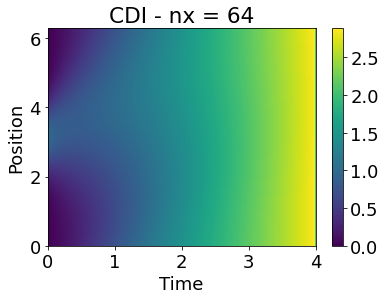

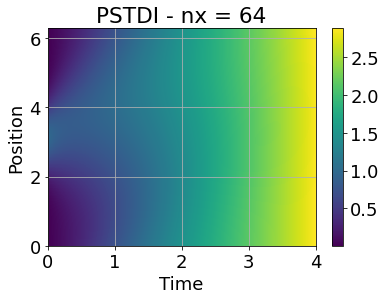

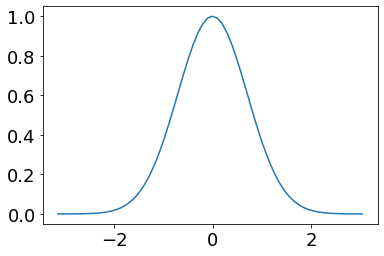

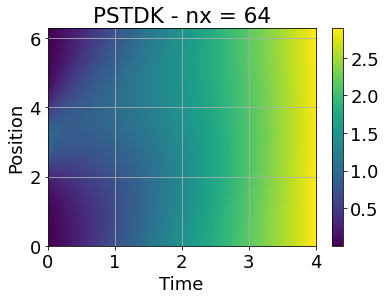

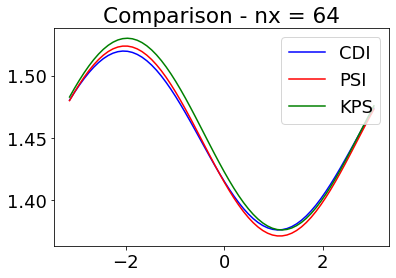

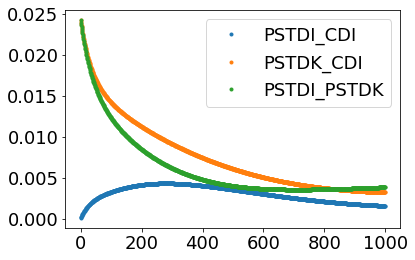

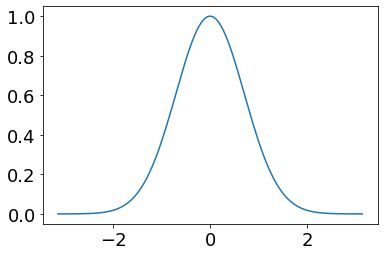

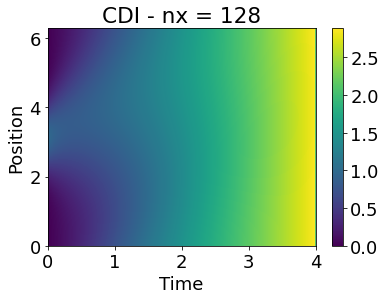

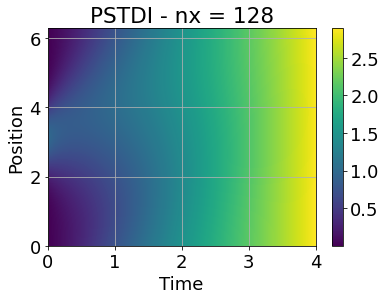

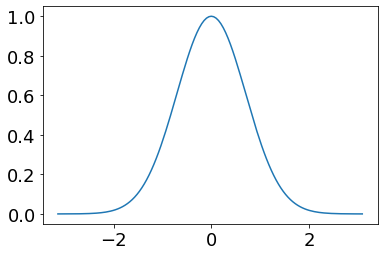

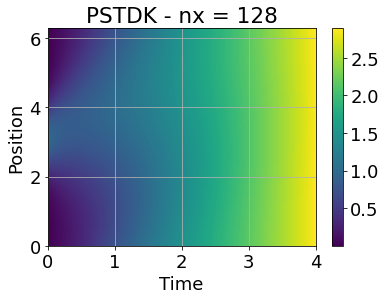

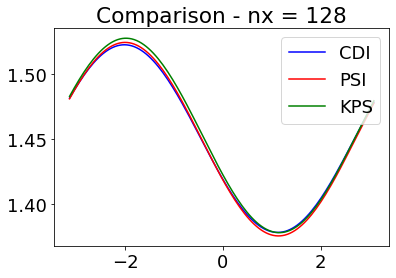

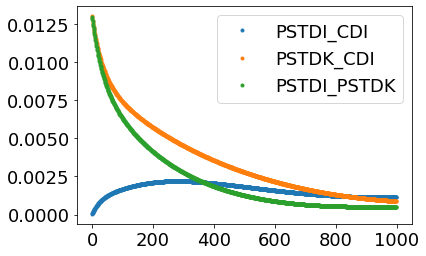

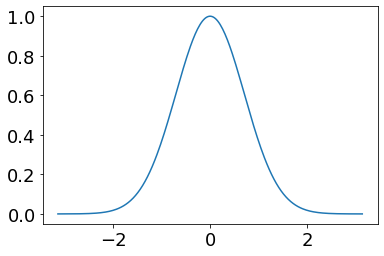

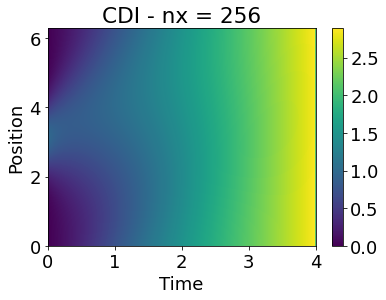

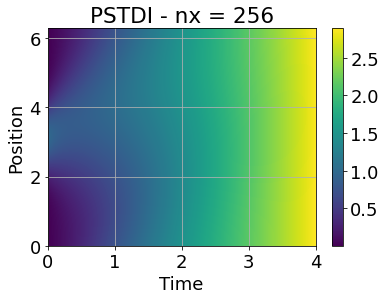

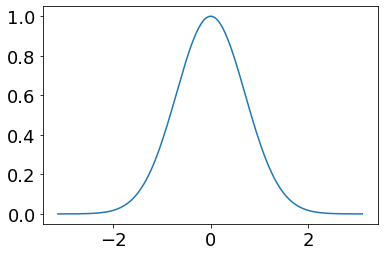

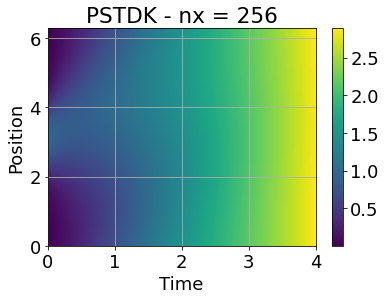

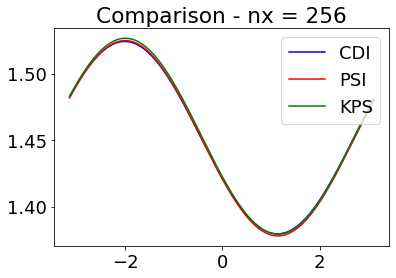

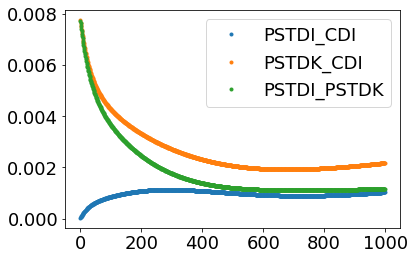

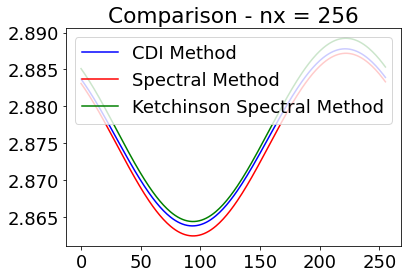

In [160]:

a = 1.0
b = 1.0
c = 0.1; 
d = 0.5

test_PS(a, b, c, d, 63, 1000)
test_PS(a, b, c, d, 127, 1000)
res = test_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()

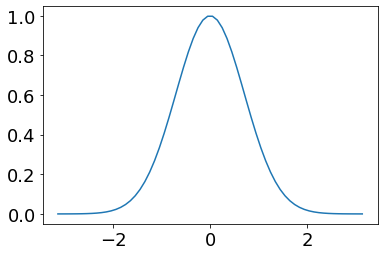

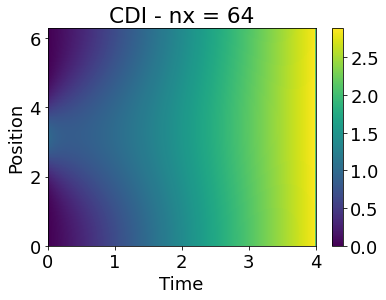

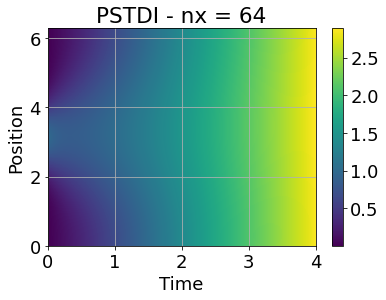

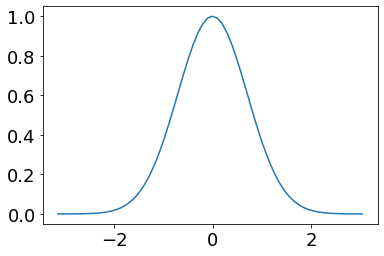

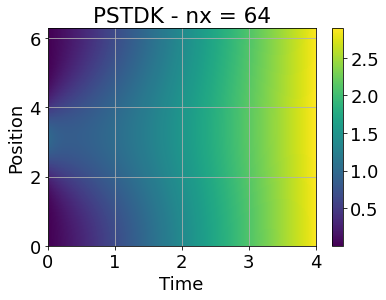

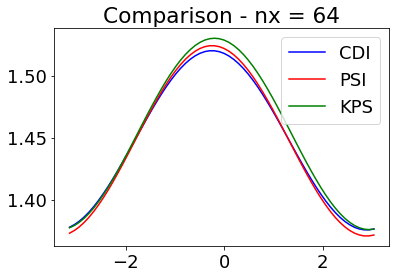

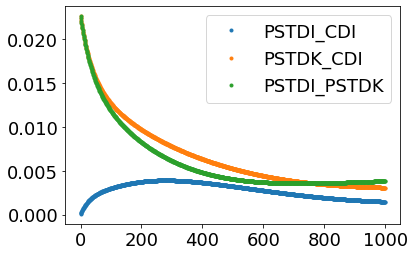

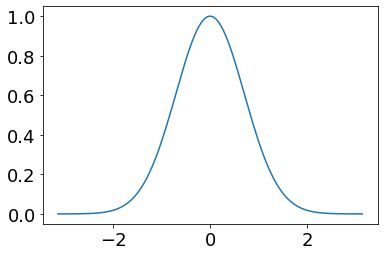

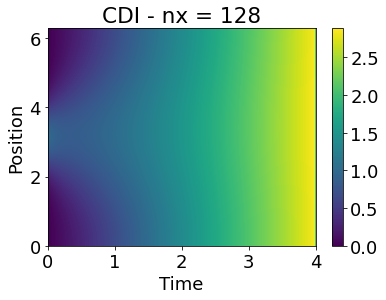

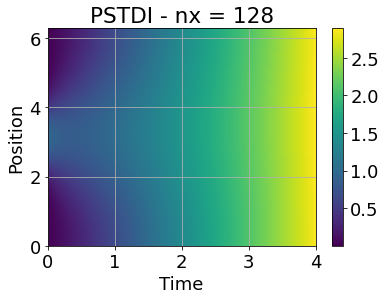

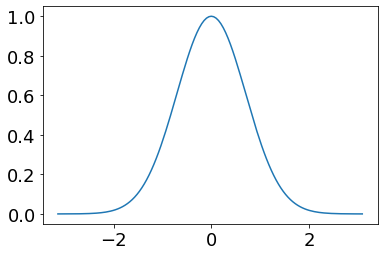

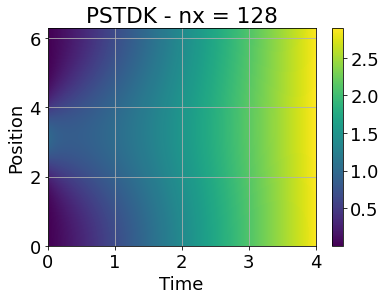

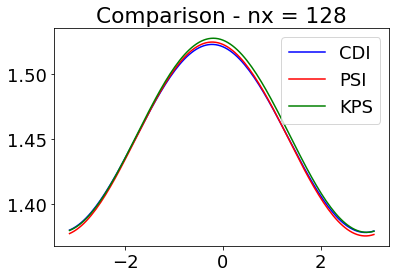

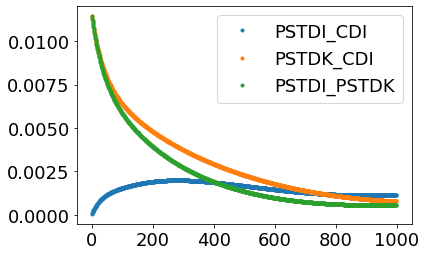

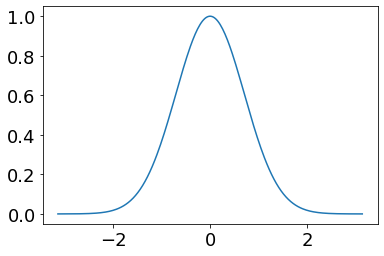

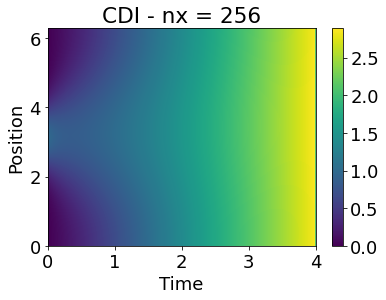

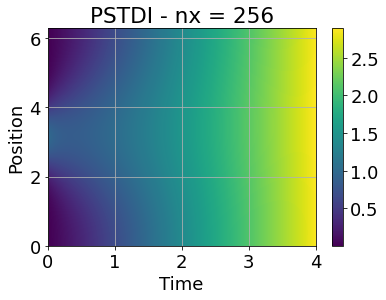

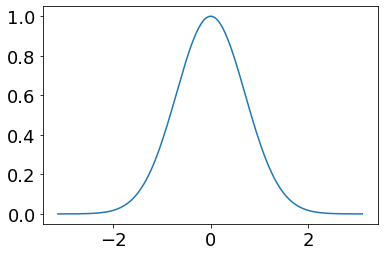

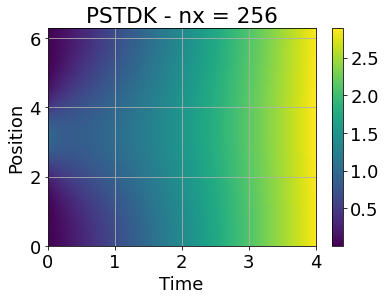

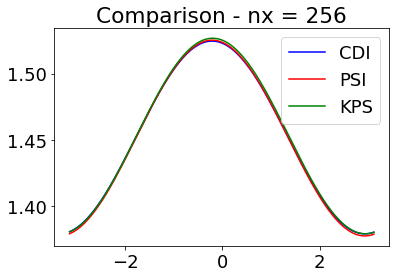

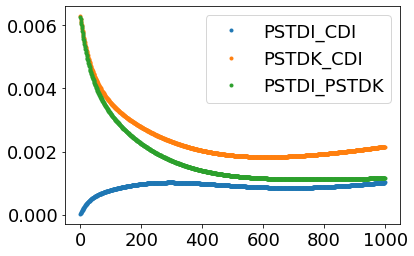

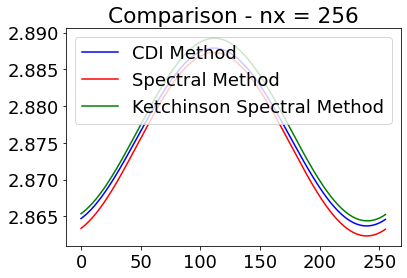

In [161]:

a = 0.1
b = 1.0
c = 0.1; 
d = 0.5

test_PS(a, b, c, d, 63, 1000)
test_PS(a, b, c, d, 127, 1000)
res = test_PS(a, b, c, d, 255, 1000)

plt.figure();
plt.plot(res[0], '-', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-', color = 'r', label = 'Spectral Method');
plt.plot(res[2], '-', color = 'g', label = 'Ketchinson Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(255+1)
plt.title(title)
plt.show()
plt.close()

# Trying to compare with the semi-infinite solutions of Ogata and Banks

### Solution for No Production Decay
    Lapidus and Amundson 1952
    Ogata and Banks 1961
    Equation: R*dC/dt = D*d2C/dx2 - v*dC/dx
    IC: C(x, 0) = Ci
    BCs:Dirichlet for 0<t<to: C(0, t) = Co
    Neumann: dC/dx(inf, t) = 0

$$ \frac {\partial U}{\partial t} = D\frac {\partial^2 U}{\partial x^2} - v\frac {\partial U}{\partial x} + c*U + d $$
$$ IC: U(x, 0) = C_i  $$
 $$  BC - Left: U(0, t) = C_o \ \ \   \ 0<t<t_o $$
 $$  BC - Right: \frac {dU(\infty, t)}{dx} = 0 $$
    $$  c = 0 $$
    $$  d = 0 $$

In [162]:
def Analytical_Ogata(a, b, c, d, L, T, nx, nt):
    # Analytical - du/dt = -v*du/dx+D*d2u/dx2

    Ci = 0; 
    Co = 2;
    # dCinf/dx = 0;
    R = 1; 
    D = b
    v = -a
    print(v, D, c, d)
    x = np.linspace(0, L, nx+1);
    t = np.linspace(0, T, nt);


    C = np.zeros((nt, nx))
    for i in range(nt):  
        for j in range(nx):      
            C[i, j] = Ci + ((Co-Ci)/2)*(erfc((x[j]-v*t[i])/(2*np.sqrt(D*t[i]/R))) + (np.exp(v*x[j]/(D/R)))*(erfc((x[j]+v*t[i])/(2*np.sqrt(D*t[i]/R)))))

    U_exact = np.transpose(C);

    fig = plt.figure()  
    plt.imshow(np.transpose(C), cmap='viridis',  extent=[0, T, L, 0], aspect='auto')
    plt.colorbar()
    plt.title("Exact")
    plt.xlabel('Time')
    plt.ylabel('Position')

    #fig.set_size_inches(30.,18.)
    # plt.savefig('U_CDI.png', dpi = 900)
    plt.show()
    
    return U_exact[:, -1]


ddfed
1.0 0.01 0 0


C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 432x288 with 0 Axes>

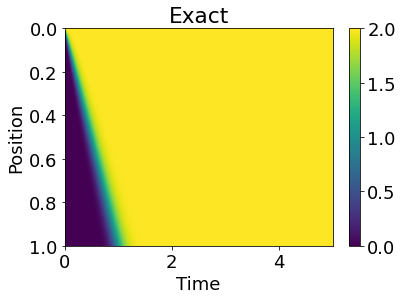

NameError: name 'testCD_PS' is not defined

In [163]:
## Ogata and Banks - No production or decay terms
axs = [-1.0, -0.1, -0.01]
bs = [0.01, 0.1]
it = 0
L = 1.0;
T = 5.0;
nx = 128;
nt = 5001; 
plt.figure()
print("ddfed")
U_compab = np.zeros((12, nx))
for a in axs:
    for b in bs: 
        pe = abs(a/b);
        # U_exact =  
        U_compab[it, :]  = Analytical_Ogata(a, b, 0, 0, L, T, nx, nt)
        U_compab[it+1, :] = testCD_PS(-a, b, 0, 0, nx-1, nt-1)
        # U_comp = comparePeclet(a, b)
        
        plt.plot(U_compab[i, :],'+-'); plt.plot(U_compab[i+1, :],'-', label = str(np.round(pe, 3)));
        plt.ylim([0, 2.1])
        # plt.title("Pe = "+str(np.round(pe, 3)))
        
        plt.xlabel("Dimensionless Time")
        plt.ylabel("Dimensionless Concentration")
        plt.title("Ogata and Banks - Different Pe="+str(np.round(pe, 3)))
        
        it = it+2

# Printing the temporal grid tests
zipped1 = list(zip(U_compab[0, :], U_compab[1, :], U_compab[2, :], U_compab[3, :], U_compab[4, :], U_compab[5, :], U_compab[6, :], U_compab[7, :], U_compab[8, :], U_compab[9, :], U_compab[10, :], U_compab[11, :]))

df2 = pd.DataFrame(zipped1, columns=['OB', 'Pe = 100.0', 'OB', 'Pe = 10.0', 'OB', 'Pe = 10.0','OB', 'Pe = 1.0','OB', 'Pe = 1.0','OB', 'Pe = 0.1'])

df2.to_csv('Analysis_OgataBanks_complete.csv', index=False)



# Didn't work - Using MMS

# MMS for the same manufactured solution as it satisfies the present condition
For an equation with given IC and periodic BCs :
$$ \frac {\partial U}{\partial t} = D\frac {\partial^2 U}{\partial x^2} + v\frac {\partial U}{\partial x}$$
$$ IC: U(x, 0) = C_i $$
$$ BC - Left: U(0, t) = -C_o $$
$$ BC - Right: U(0, t) = -C_o $$
$$ BC - Left: \frac {dU(0, t)}{dx} = 0 $$
$$ BC - Right: \frac {dU(1, t)}{dx} = 0 $$

The chosen equation is: 
$$ U(x,t) = C_o \cos(\pi(2x -1)) e^{-t}$$

The initial and boundary condition terms: I.C.: Ci*sin(pi*x)
        Boundary Conditions: Periodic BC
$$ U(x, 0) = C_o\cos( \pi(2x -1))$$
$$ U(0, t) = -C_o e^{-t} $$
$$ U(1, t) = -C_o e^{-t} $$

$$ \frac {dU}{dx} (0, t) = -2\pi C_o\sin( \pi(2*0 -1)) e^{-t} = 0$$ 
$$ \frac {dU}{dx} (1, t) = -2\pi C_o\sin(\pi(2*1 -1)) e^{-t} = 0$$ 

The derivative terms are:

$$ \frac {dU}{dt} = -C_o\cos(\pi (2*x-1)) e^{-t}$$
$$ \frac {dU}{dx} = -C_o 2 \pi \sin(\pi (2*x-1)) e^{-t}$$
$$ \frac {d^2U}{dx^2} = -C_o 4 \pi^2 \cos(\pi (2*x-1)) e^{-t}$$

The new source term will be:
    
$$ d = \frac {dU}{dt} - v*\frac {dU}{dx}  - D*\frac {d^2U}{dx^2}$$
$$ d = -C_o\cos(\pi (2*x-1)) e^{-t} - v*2*C_o\pi \sin(\pi (2*x-1)) e^{-t} - D*C_o*4*\pi^2 \cos(\pi (2*x-1)) e^{-t}$$
$$ d =  -C_o e^{-t}(\cos(\pi (2*x-1)) - v*2*\pi \sin(\pi (2*x-1)) - D*4*\pi^2 \cos(\pi (2*x-1))) $$

In [28]:
def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = b*dt/dx
        beta = a*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt    


        
        u_CDI = solve(A, bi)

        return u_CDI


In [29]:
def numerical_scheme_PSTD(u, a, b, c, d, k, dx, dt):
        uk = np.fft.rfft(u)
        
        uk[:] = (uk[:])/(1-(-a*k**2 + b*1j*k+c)*dt) 
        u = np.fft.irfft(uk) + d*dt
        return u

In [30]:
# Creating function for running the code and getting the error with different number of nodes with left dirichlet and right neumann condition. 
def numericalcodes(nx, nt): 
    # Define the grid
    a = 1.0;
    b = 0.01;
    c = 0.0;
    Co = 1.0;
    L = 1.0
    T = 1.0
    dm = np.zeros((nx+1, nt+1));
    U_exact = np.zeros((nx+1, nt+1));
    # Define x & t
    x = np.linspace(0, L, nx+1)
    t = np.linspace(0, T, nt+1)
    for i in range(nt+1):
        for j in range (nx+1):
            dm[j, i] = -(Co*np.exp(-t[i]))*(np.cos(np.pi*(2*x[j]-1)) - 2*b*np.pi*np.sin(np.pi*(2*x[j]-1)) - a*4*(np.pi**2)*np.cos(np.pi*(2*x[j]-1)))
    
    for i in range(nt+1):
        for j in range (nx+1):
            U_exact[j, i] = Co*np.cos(np.pi*(2*x[j]-1))*np.exp(-t[i])
    fig = plt.figure()  
    plt.imshow((U_exact), cmap='viridis',  extent=[0, L, 0, T], aspect='auto')
    plt.colorbar()
    plt.title("Exact")
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()

    # Defining variables and errors
    U_CDI = np.zeros((nx+1, nt+1))
    U_ps = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)
    error_2norm_Exact_CDI = np.zeros(nt+1)
    error_2norm_Exact_PSTD = np.zeros(nt+1)
    
    # Discretization of space and time
    dx = L/(nx)
    dt = T/(nt)
    
    print("\n here \n")
    print(dx)
    print(x[1])
    print(dt)
    print(t[1])
    print("\n here \n")
    u = Co*np.cos(np.pi*(2*x-1)) # np.zeros(nx);
    u_ps = u;
    u_CDI=u;
    u1 = u
    k = 2*np.pi*np.fft.rfftfreq(nx+1, L/(nx))    
    
    # Solving over time
    for i in range(nt+1):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, dm[:, i], dx, dt)
        u_ps = numerical_scheme_PSTD(u_ps, a, b, c, dm[:, i], k, dx, dt)
        if(i<2):
            u1= u_ps
        U_CDI[:, i] = u_CDI
        U_ps[:, i] = u_ps
        error =  U_CDI[:, i] - U_ps[:, i]
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
        
        error =  U_ps[:, i] - U_exact[:, i]
        error_2norm_Exact_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
        errorPSTD = error_2norm_Exact_PSTD[i]
        
        error =  U_CDI[:, i] - U_exact[:, i]
        error_2norm_Exact_CDI[i] =np.linalg.norm(error)/np.sqrt(nx)
        errorCDI = error_2norm_Exact_CDI[i]

    # Errors at time 1s for the two methods(CDI, PSTD) and 7 number of nodes (dx in 20, 40, 60, 80, 100, 120, 150)
    errornorms = np.ones(7)
    errornorms[0] = errorCDI
    errornorms[1] = errorPSTD
    
    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()

    plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure();
    plt.plot(x, u, '-', color='g', label = 'Initial'); 
    plt.plot(x, u1, '-', color='c', label = 'InitialPS'); 
    
    plt.plot(x, U_CDI[:, nt-1], '-*', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, nt-1], '-+', color = 'r', label = 'Spectral Method');
    plt.plot(x, U_exact[:, nt-1], '.-', color = 'k', label = 'Exact');
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt+1], '.', label = 'PSTDI_CDI')
    plt.plot(error_2norm_Exact_PSTD[0:nt+1], '.', label = 'Exact_PSTD')
    plt.plot(error_2norm_Exact_CDI[0:nt+1], '.', label = 'Exact_CDI')
    plt.legend()
    plt.show()
    plt.close()
    return errornorms
    

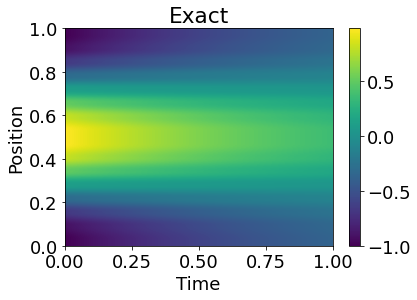


 here 

0.06666666666666667
0.06666666666666667
0.001
0.001

 here 



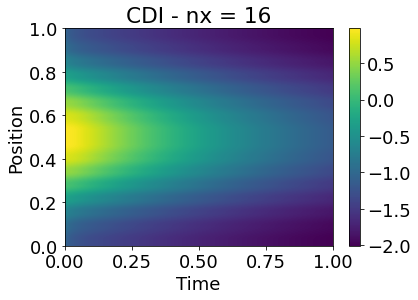

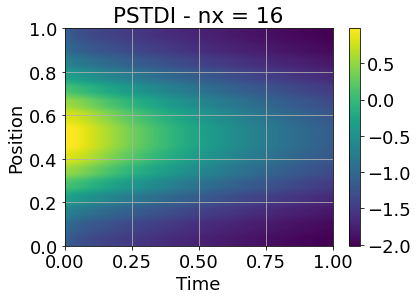

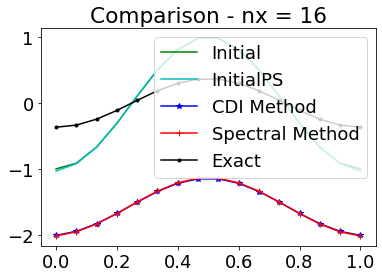

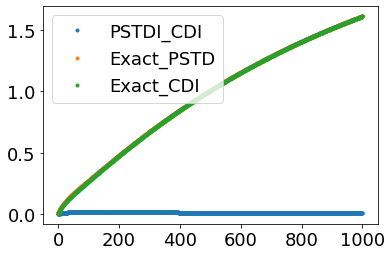

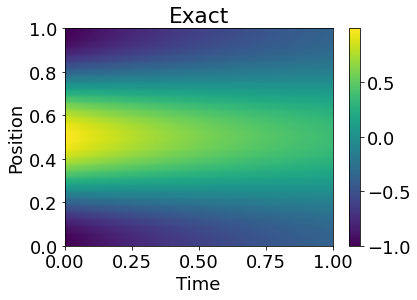


 here 

0.03225806451612903
0.03225806451612903
0.001
0.001

 here 



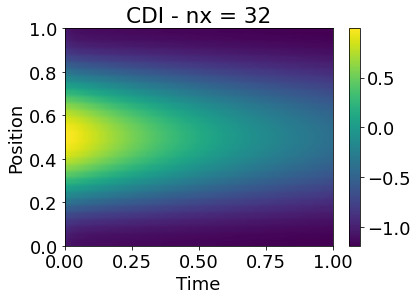

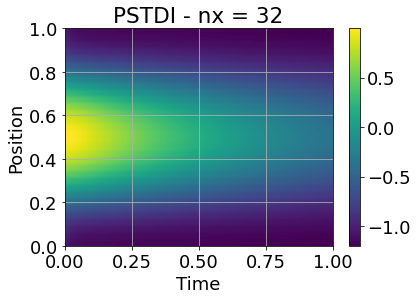

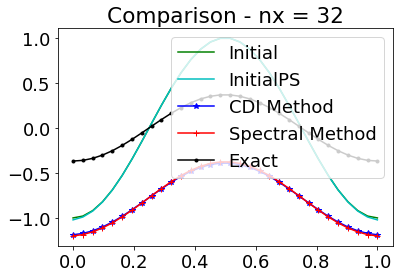

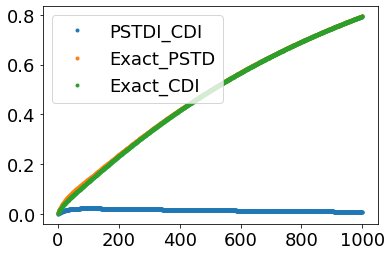

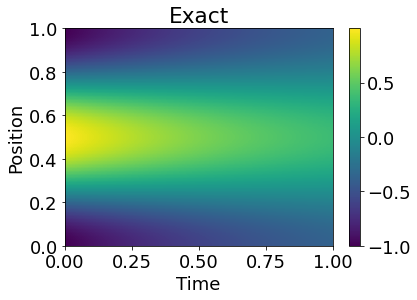


 here 

0.015873015873015872
0.015873015873015872
0.001
0.001

 here 



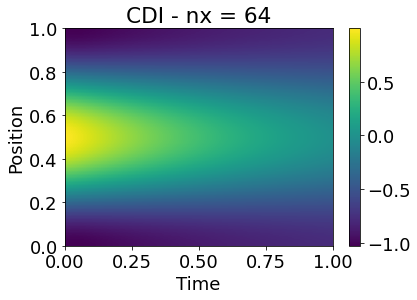

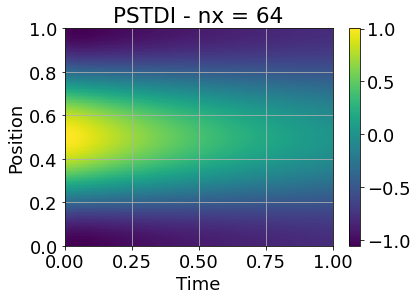

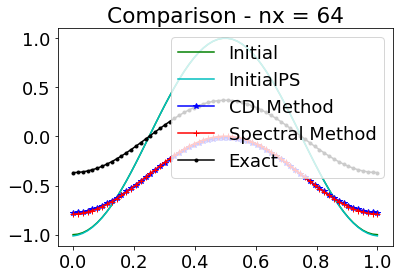

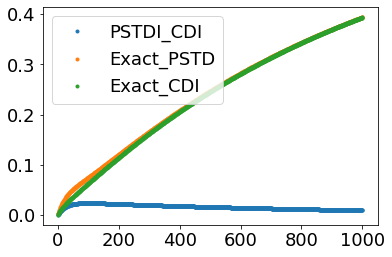

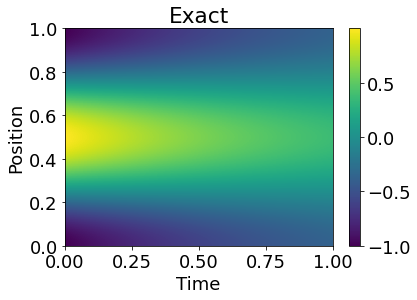


 here 

0.007874015748031496
0.007874015748031496
0.001
0.001

 here 



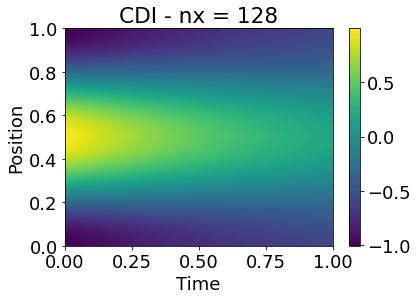

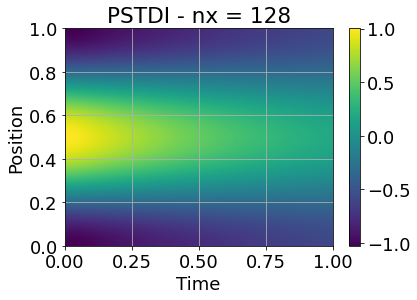

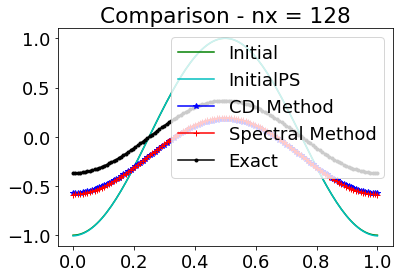

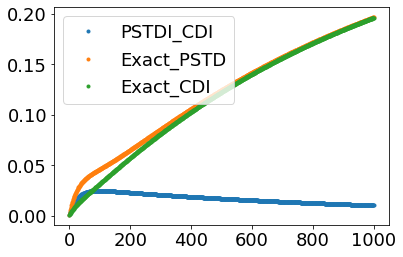

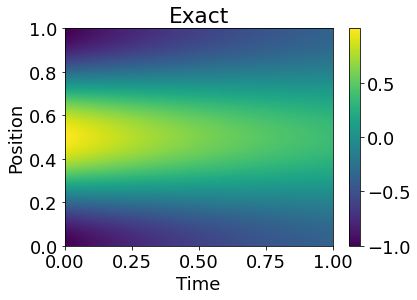


 here 

0.00392156862745098
0.00392156862745098
0.001
0.001

 here 



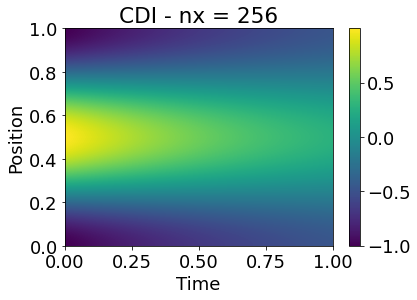

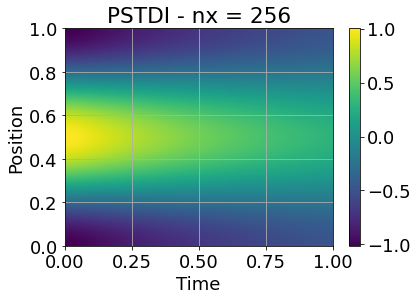

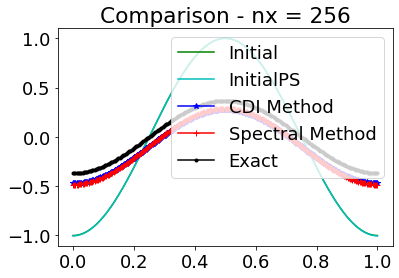

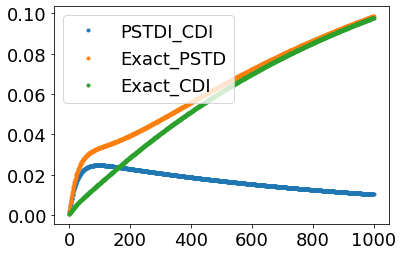

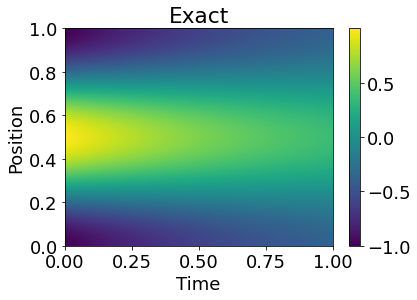


 here 

0.0019569471624266144
0.0019569471624266144
0.001
0.001

 here 



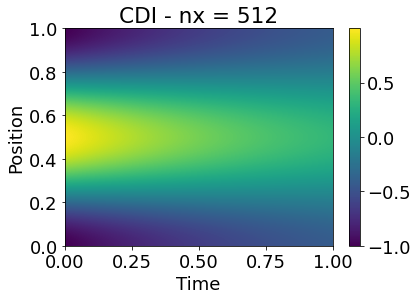

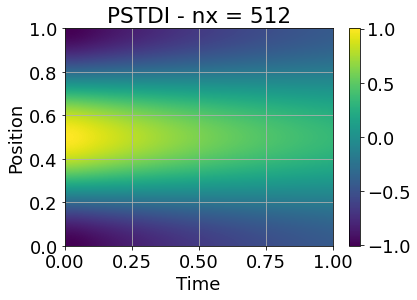

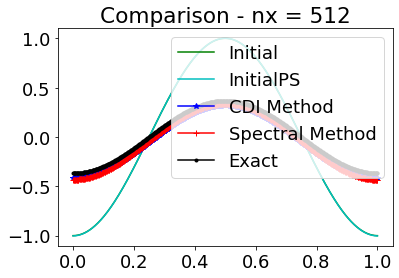

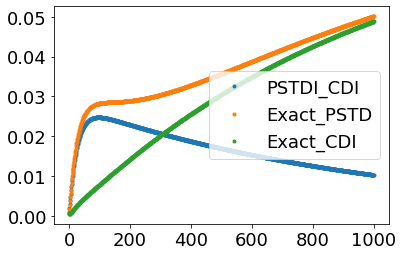

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


<Figure size 720x144 with 0 Axes>

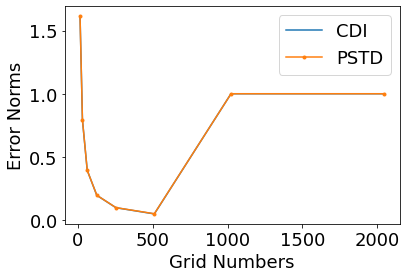

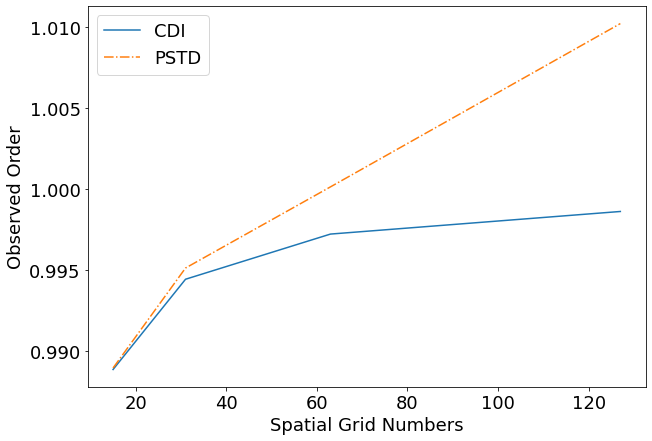

In [31]:
# Equation with decay terms 

# Spatial MMS tests
errorsx = np.ones((8, 2))
errornorms = np.ones(8)
nx = 32;
nt = 1000;
nxs = [15, 31, 63, 127, 255, 511, 1023, 2047]
nts = [250, 500, 1000, 2000, 4000]
for i in range(6):
    errornorms = numericalcodes(nxs[i], nt)
    errorsx[i, 0] = errornorms[0]
    errorsx[i, 1] = errornorms[1]
fig = plt.figure()
plt.figure()
fig.set_size_inches(10.,2.)
plt.plot(nxs, errorsx[:, 0], '-', label = 'CDI')
plt.plot(nxs, errorsx[:, 1], '.-', label = 'PSTD')

plt.xlabel('Grid Numbers')
plt.ylabel('Error Norms')
plt.legend()

fig = plt.figure()
fig.set_size_inches(10.,7.)
px = np.zeros((6, 2))
for g in range(6):
    for k in range(2):
        px[g, k] = np.log((np.abs(errorsx[g+2, k]) - np.abs(errorsx[g+1, k]))/(np.abs(errorsx[g+1, k]) - np.abs(errorsx[g, k])))/(np.log(nxs[g]/nxs[g+1]))

plt.plot(nxs[0:6], px[:, 0], '-', label = 'CDI')
plt.plot(nxs[0:6], px[:, 1], '-.', label = 'PSTD')

plt.xlabel('Spatial Grid Numbers')
plt.ylabel('Observed Order')
plt.legend()

# Printing the spatial grid tests

zipped1 = list(zip(nxs, errorsx[:, 0], errorsx[:, 1], px[:, 0], px[:, 1]))
df2 = pd.DataFrame(zipped1, columns=['Spatial Discretization Numbers', 'CDI_Error', 'PSTD_Error', 'CDI_Order', 'PSTD_Order'])

df2.to_csv('Analysis_Spatial25_Complete.csv', index=False)


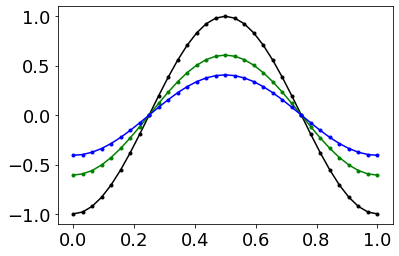

In [32]:
a = 1.0;
b = 0.01;
c = 0.0;
Co = 1.0;
L = 1.0
T = 1.0
dm = np.zeros((nx+1, nt+1));
U_exact = np.zeros((nx+1, nt+1));
# Define x & t
x = np.linspace(0, L, nx+1)
t = np.linspace(0, T, nt+1)
for i in range(nt+1):
    for j in range (nx+1):
        U_exact[j, i] = Co*np.cos(np.pi*(2*x[j]-1))*np.exp(-t[i])


plt.plot(x, U_exact[:, 1], '.-', color = 'k', label = 'Exact0');
plt.plot(x, U_exact[:, 500], '.-', color = 'g', label = 'Exact500');
plt.plot(x, U_exact[:, 900], '.-', color = 'b', label = 'Exact900');

In [33]:
def tests2(a, b, c, d, nx, nt):

    L = 1.0
    T = 1.0


    x = np.linspace(0, L, nx+1)
    t = np.linspace(0, T, nt+1)
    xin = np.linspace(0, L, nx+1);
    u = np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)

    # Discretization of space and time
    dx = L/(nx-1)
    dt = T/(nt+1)


    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = a*dt/dx
        beta = b*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta[j]-alpha[j]/2)
            A[j, j] = 1+2*beta[j]-c[j]*dt
            A[j, j+1] = -(beta[j]+alpha[j]/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta[0])-c[0]*dt;
        A[0, 1]= (-alpha[0]/2-beta[0])
        A[0, nx]= (alpha[0]/2-beta[0])    


        A[nx, 0]= (-alpha[nx]/2-beta[nx]) ;
        A[nx, nx-1]= (alpha[nx]/2 - beta[nx])
        A[nx, nx]= 1+2*beta[nx]-c[nx]*dt    

        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_QI_PSTD = np.zeros(nt)

    u_CDI=u;

    for n in range(nt):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt)
        U_CDI[:, n] = u_CDI

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, T, 0, L], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()


    k = 2*np.pi*np.fft.rfftfreq(nx+1, L/(nx))
    k2=k**2;

    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))

    # Solving over time
    for i in range(nt+1): # 
        
        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-b*k**2 + a*1j*k+c)*dt) 
        u = np.fft.irfft(uk) + d*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
 

    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, T, 0, L], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure();
    plt.plot(x, ui, '-', color='g', label = 'Initial'); 

    plt.plot(x, U_CDI[:, nt-1], '-*', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, nt-1], '-+', color = 'r', label = 'Spectral Method');
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1]]
    # print(np.shape(res))
    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    plt.legend()
    plt.show()
    plt.close()
    return res

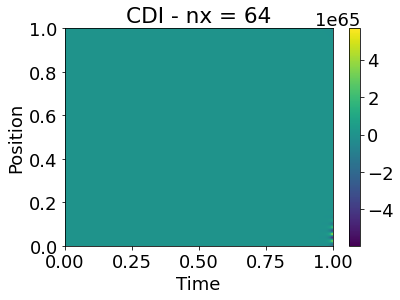

ValueError: operands could not be broadcast together with shapes (64,) (33,) 

In [34]:
nx = 63
x = np.linspace(0,1, nx+1)
a = 1.0*np.sin(np.pi*x)
b = 0.01*np.cos(np.pi*x)
c = a+10*b; 
d = a-10*b;

tests2(a, b, c, d, nx, 1000)

nx = 127
x = np.linspace(0,1, nx+1)
a = 1.0*np.sin(np.pi*x)
b = 0.01*np.cos(np.pi*x)
c = a+10*b; 
d = a-10*b;
tests2(a, b, c, d, nx, 1000)

nx = 255
x = np.linspace(0,1, nx+1)
a = 1.0*np.sin(np.pi*x)
b = 0.01*np.cos(np.pi*x)
c = a+10*b; 
d = a-10*b;
res = tests2(a, b, c, d, nx, 1000)
print('ldd')
plt.figure();
plt.plot(res[0], '-*', color='b', label = 'CDI Method'); 
plt.plot(res[1], '-+', color = 'r', label = 'Spectral Method');
plt.legend(loc="upper right")
title = "Comparison - nx = "+str(nx+1)
plt.title(title)
plt.show()
plt.close()
